# Zebra page separation A/B Test Analysis Report 2: 
# Edits ( clicks on edit and edit source button)
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bugs: [T336969](https://phabricator.wikimedia.org/T336969)  [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Introduction

The Wikimedia Foundation's Web team is exploring a new page separation in vector-2022 skin. The current Vector 2022 interface uses whitespace to separate the various regions and has a white page background. The proposed new page interface uses gray background  to separate the various regions. The team hope the new layout separation will help users focus on the content and reduce the eye strain experienced by some individuals.  

To evaluate the impact of introducing the new page separation , an AB test was conducted on the desktop logged-in users with vector-2022 skin between May 29,2023 and Jun 20, 2023. The experiment only took place on the following test wikis:  hewiki, enwiki, fawiki, frwiki, kowiki, ptwiki, srwiki, thwiki, trwiki, viwiki.


__The default Vector-2022 layout with a white background__    
<img src="Figures/default_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__The new layout (Zebra) with a gray background outside of the content area__.     
<img src="Figures/zebra_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />     

# Purpose

The primary goal of the AB Test was to test two hypothesis:
1. There is no significant change on pageviews with the new layout separation.
2. There is no significant change on edits with the new layout separation.

We also sought to answer three curiosity questions:
1. Does it impact the usage of TOC as the new layout separated ToC and content into different boxes?
2. Does it impact the usage of Page tools? (Number of pins or unpins)
3. Does it impact the scrolling to top behavior? (Nice to have)

This report focuses on the impact on __edits__.The other reports will detail the analysis and results of the impact on pageviews, ToC usage, scrolling and page tools usage. 


# Methodology

The AB test was run on a per wiki basis on logged-in users with Vector-2022 skin. Users included in the test were randomly assigned to either the control (default) or treatment (new page separation) based on their local user ID.

We reviewed AB test data recorded from 02 Jun 2023 through 19 Jun 2023 for this analysis. Data was limited to pageviews and edits completed by desktop logged-in users who were selected in the AB test.

We compared the number of edits between control and treatment groups, and ran hierarchical generalized linear modeling on session based data to determine whether the difference is statistically significant. We also reviewed the edit rate in each edit bucket and wiki. As users could switch edit count groups during the experiment if their accumulated contributions reached a threshold, we categorized the sessions based on their edit count bucket at the beginning of the experiment.

Note that we excluded data collected from May 29 2023  to June 1 2023 in this analysis due to a bug which caused the edit button to be missing on the sticky header.

In [20]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [6]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [7]:
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [36]:
#for blas_set_num_threads()
library(RhpcBLASctl)

In [35]:
# for glmmTMB()
library(glmmTMB)

In [10]:
# for r.squaredGLMM
library(MuMIn)

In [11]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Check when edit button clicks recovered after the fix of [T337955](https://phabricator.wikimedia.org/T337955)

In [159]:
query_daily <- "
SELECT  TO_DATE(dt) AS event_date,t3.wiki,event.name as event_name,
count(distinct t3.event.token) AS session_n,
count(1) AS edit_clicks
FROM event.desktopwebuiactionstracking AS t3
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month IN (4,5,6)
--AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND NOT event.isanon 
AND event.action='click' 
AND event.name IN ('ca-edit','ca-ve-edit', 'wikitext-edit-sticky-header', 've-edit-sticky-header' )
AND event.skinversion=2 
GROUP BY  TO_DATE(dt), t3.wiki, event.name
"

In [160]:
df_daily  <- wmfdata::query_hive(query_daily)

Don't forget to authenticate with Kerberos using kinit



In [162]:
df_daily$event_date <- as.Date(df_daily$event_date)

In [163]:
df_daily

event_date,wiki,event_name,session_n,edit_clicks
<date>,<chr>,<chr>,<int>,<int>
2023-05-22,hewiki,wikitext-edit-sticky-header,1,1
2023-06-12,frwiki,ve-edit-sticky-header,90,160
2023-04-24,ptwiki,wikitext-edit-sticky-header,5,5
2023-05-08,enwiki,ca-ve-edit,191,719
2023-05-19,srwiki,ve-edit-sticky-header,9,18
2023-05-01,enwiki,ca-edit,5702,23822
2023-06-05,hewiki,wikitext-edit-sticky-header,1,1
2023-06-26,frwiki,ve-edit-sticky-header,79,162
2023-05-08,ptwiki,wikitext-edit-sticky-header,3,4


In [179]:
df_daily %>%
 filter(event_name=='wikitext-edit-sticky-header'| event_name=='ve-edit-sticky-header')%>%
 filter(event_date>'2023-05-01')%>%
    group_by(event_date) %>%
    summarize(sum_session=sum(session_n), sum_edit_clicks=sum(edit_clicks), .groups='drop')

event_date,sum_session,sum_edit_clicks
<date>,<int>,<int>
2023-05-02,927,1824
2023-05-03,898,1869
2023-05-04,828,1653
2023-05-05,830,1501
2023-05-06,624,1283
2023-05-07,676,1318
2023-05-08,891,1751
2023-05-09,871,1765
2023-05-10,932,1854


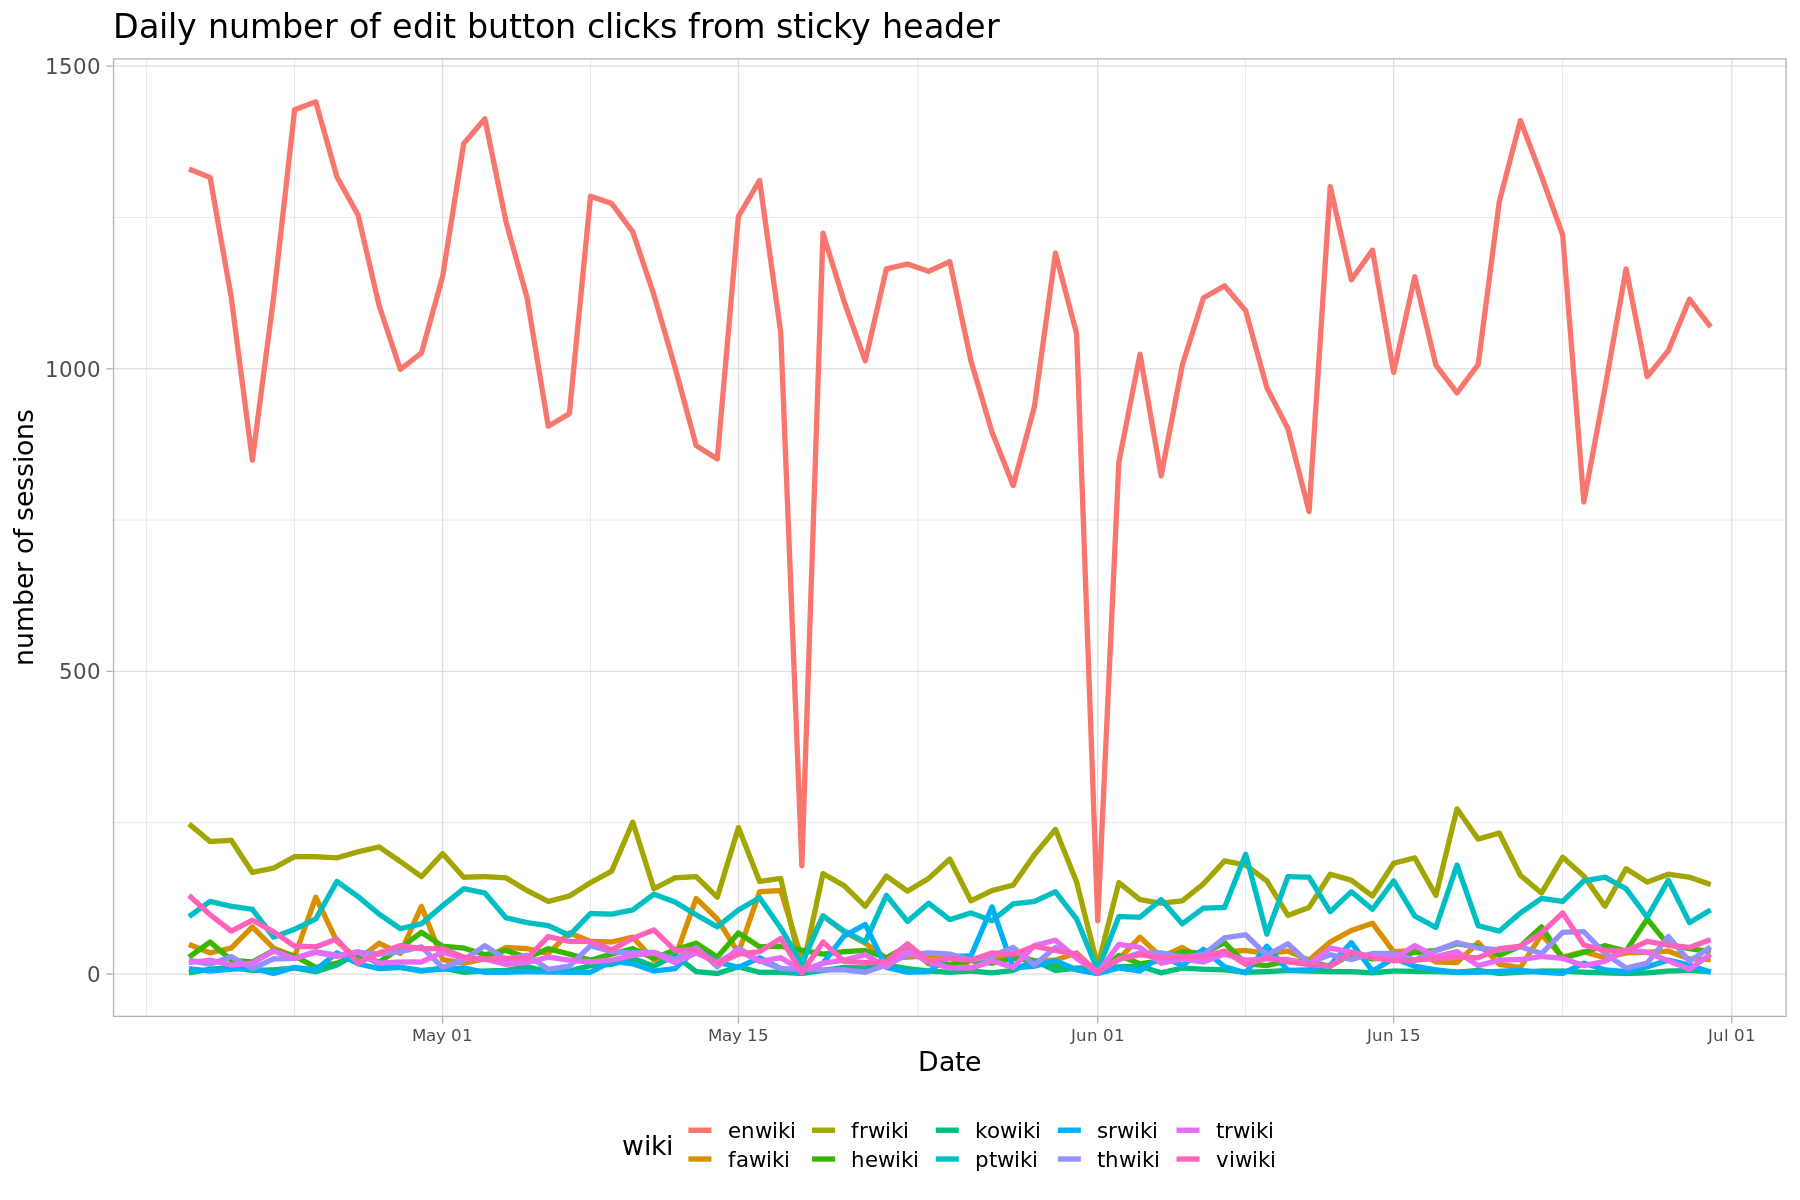

In [185]:
g_daily <- df_daily %>%
 filter(event_name=='wikitext-edit-sticky-header'| event_name=='ve-edit-sticky-header')%>%
    group_by(event_date, wiki) %>%
    summarize(sum_session=sum(session_n), sum_edit_clicks=sum(edit_clicks), .groups='drop') %>%
    ggplot(  mapping=aes(x=event_date, y= sum_edit_clicks, color=wiki)) +
geom_line( size = 1.5) +
labs(title = 'Daily number of edit button clicks from sticky header',
     x = 'Date',
     y = 'number of sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_daily

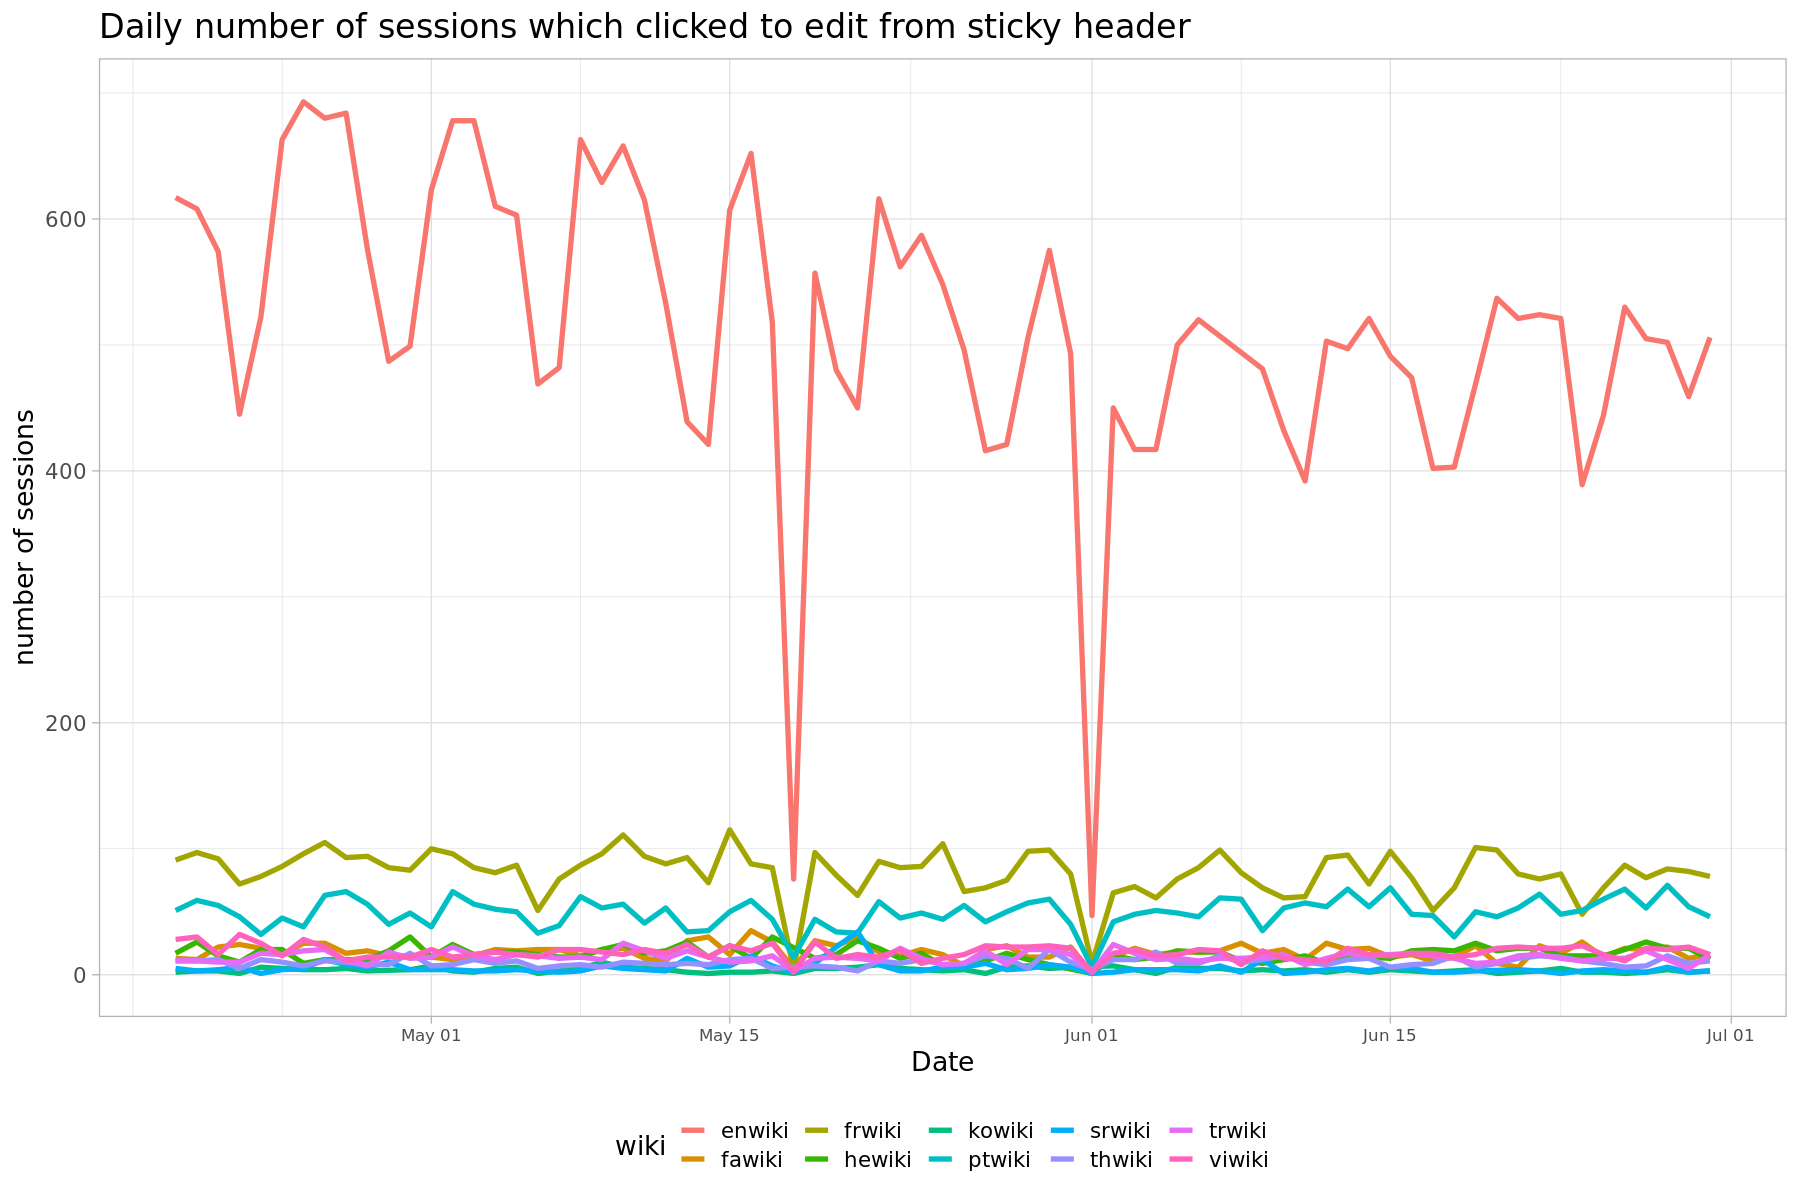

In [ ]:
g_daily <- df_daily %>%
 filter(event_name=='wikitext-edit-sticky-header'| event_name=='ve-edit-sticky-header')%>%
    group_by(event_date, wiki) %>%
    summarize(sum_session=sum(session_n), sum_edit_clicks=sum(edit_clicks), .groups='drop') %>%
    ggplot(  mapping=aes(x=event_date, y= sum_session, color=wiki)) +
geom_line( size = 1.5) +
labs(title = 'Daily number of sessions which clicked to edit from sticky header',
     x = 'Date',
     y = 'number of sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_daily

### Note

The daily number of edit button clicks and number of sessions from sticky header, as collected by DesktopWebUIActionsTracking , only had a dip around June 1, 2023 as the effect of missing editing button on the sticky header. 

The events of edit button clicks from sticky header recovered since June 1, 2023 at 21:00 UTC.

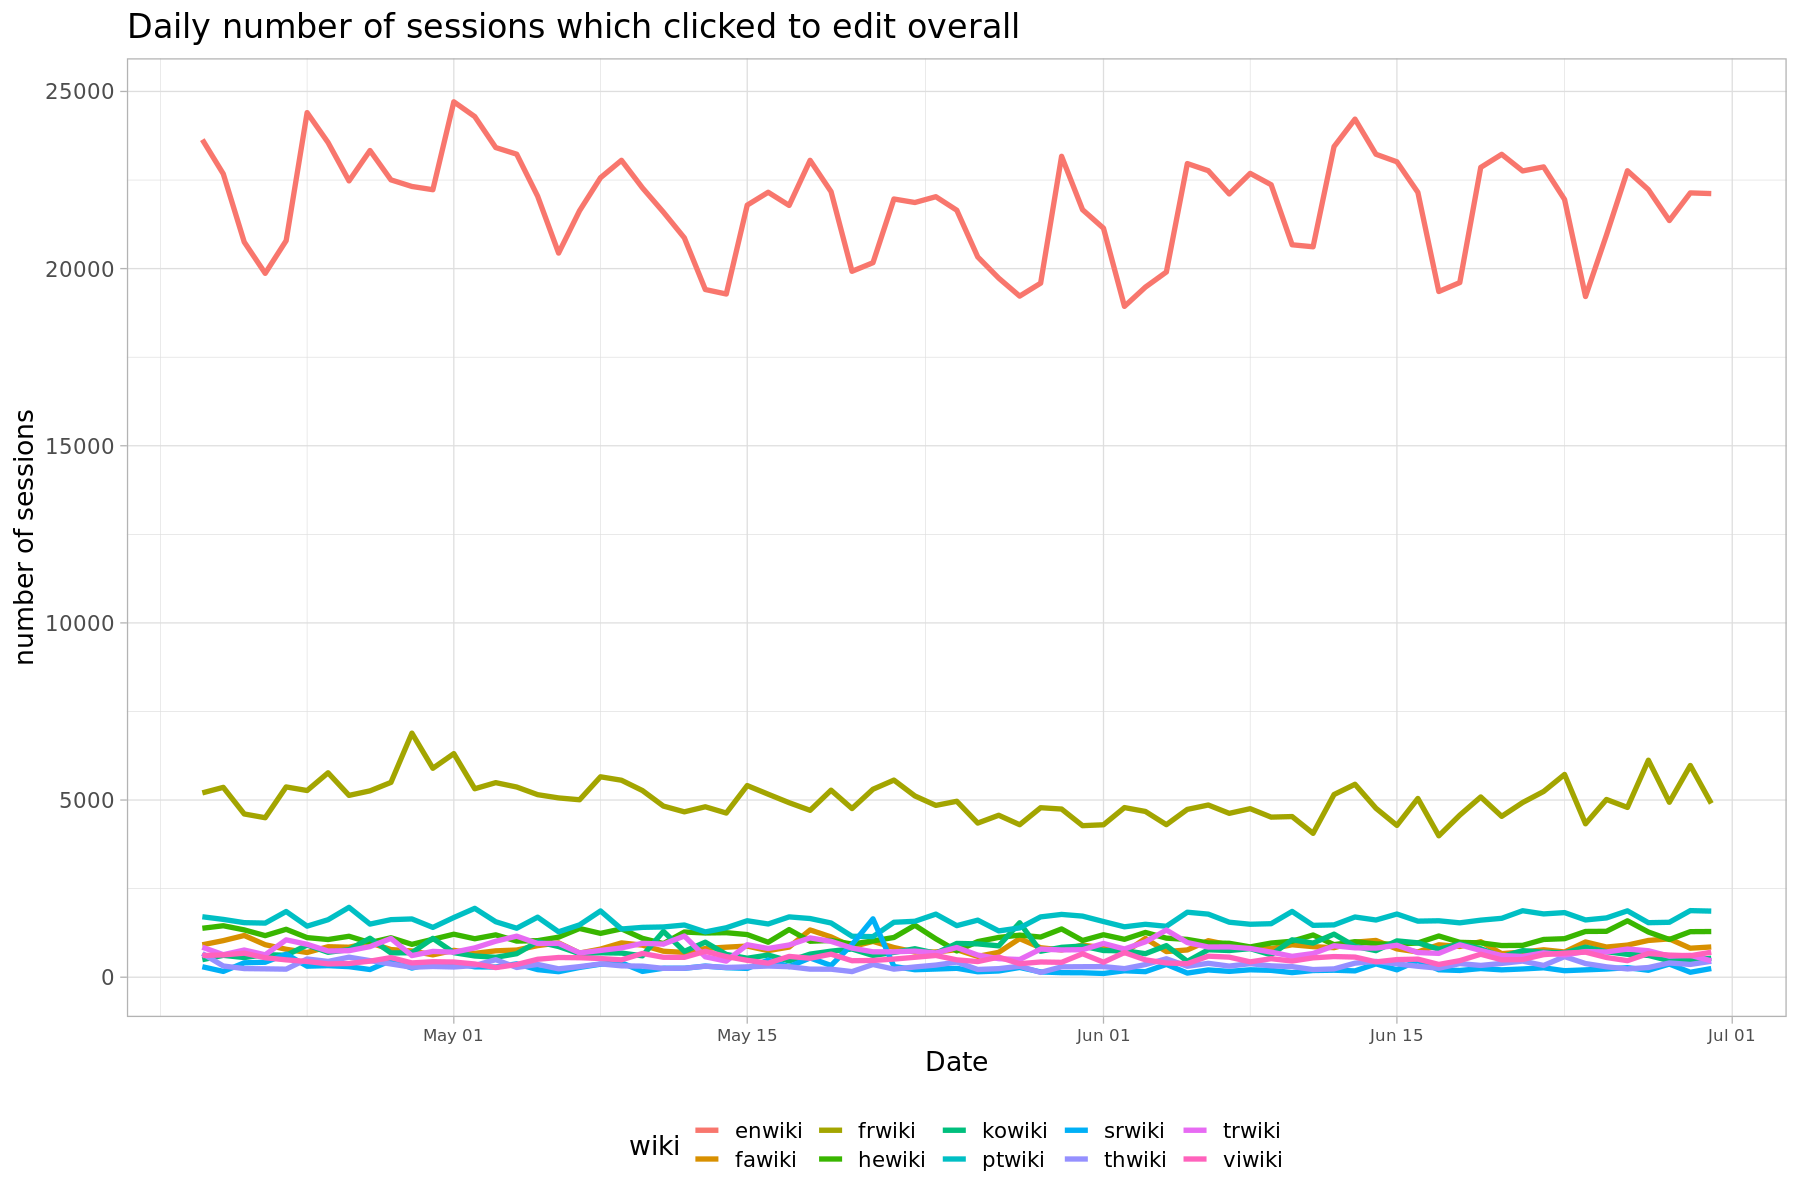

In [181]:
g_daily <- df_daily %>%
 filter(event_name=='ca-edit'| event_name=='ca-ve-edit')%>%
    group_by(event_date, wiki) %>%
    summarize(sum_session=sum(session_n), sum_edit_clicks=sum(edit_clicks), .groups='drop') %>%
    ggplot(  mapping=aes(x=event_date, y= sum_edit_clicks, color=wiki)) +
geom_line( size = 1.5) +
labs(title = 'Daily number of sessions which clicked to edit overall',
     x = 'Date',
     y = 'number of sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_daily

# Query data or import data

As discovered in QA [T336299](https://phabricator.wikimedia.org/T336299), we should 
1) exclude sessions which were assigned to both control group and treatment group. They constitute 0.12% of total sessions. 
2) exclude 466 sessions from bot users.

query_pageviews <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- pageviews from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token, 
t3.wiki, t3.event.editCountBucket,  t4.test_group, 
-- event.viewportSizeBucket AS view_size,
count(1) AS pvs
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='init' AND event.skin='vector-2022'
GROUP BY  t3.event.token ,t3.event.pageToken, t3.wiki, t3.event.editCountBucket,  t4.test_group 
"

In [22]:
#df_pageviews <- wmfdata::query_hive(query_pageviews)

Don't forget to authenticate with Kerberos using kinit



In [9]:
df_pageviews <- read.csv("Data/pageviews_20230725.csv")

In [10]:
dim(df_pageviews)

[1] 19921367        6

In [4]:
query_edit_clicks <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  and month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks on edit button from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token,
t3.wiki,   t4.test_group, 
count(1) AS edit_clicks
FROM event.desktopwebuiactionstracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='click' 
AND event.name IN ('ca-edit','ca-ve-edit')
AND event.skin='vector-2022'
GROUP BY  t3.event.token ,  t3.event.pageToken,  t3.wiki, t4.test_group 
"


In [5]:
df_edit_clicks <- wmfdata::query_hive(query_edit_clicks)

Don't forget to authenticate with Kerberos using kinit



In [6]:
dim(df_edit_clicks)

[1] 519995      5

In [7]:
summary(df_edit_clicks)

  session_id         page_token            wiki            test_group       
 Length:519995      Length:519995      Length:519995      Length:519995     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  edit_clicks    
 Min.   : 1.000  
 1st Qu.: 1.000  
 Median : 1.000  
 Mean   : 1.101  
 3rd Qu.: 1.000  
 Max.   :69.000  

In [11]:
df_edit_pv <- merge( df_pageviews,df_edit_clicks ,by.x=c("session_id","page_token","wiki","test_group"), by.y=c("session_id","page_token","wiki","test_group"),all.x=TRUE )

In [12]:
summary(df_edit_pv)

  session_id         page_token            wiki            test_group       
 Length:19921367    Length:19921367    Length:19921367    Length:19921367   
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 editcountbucket         pvs     edit_clicks      
 Length:19921367    Min.   :1   Min.   : 1        
 Class :character   1st Qu.:1   1st Qu.: 1        
 Mode  :character   Median :1   Median : 1        
                    Mean   :1   Mean   : 1        
                    3rd Qu.:1   3rd Qu.: 1        
                    Max.   :3   Max.   :69        
                           

In [29]:
df_edit_pv$edit_clicks[is.na(df_edit_pv$edit_clicks)] <- 0

In [211]:
df_edits_pvs_per_session <- df_edit_pv %>%
  # some session switched editcountbucket during experiment, mostly from 0 edit to 1-4 edits group, drop editcountbucket for session based analysis
   group_by(session_id, wiki, test_group) %>%
   summarize(sum_pvs=sum(pvs), sum_pv_pages=n_distinct(page_token),
             sum_edit_clicks=sum(edit_clicks), .groups='drop')

# Data exploration

In [212]:
summary(df_edits_pvs_per_session)

  session_id            wiki            test_group           sum_pvs     
 Length:1106811     Length:1106811     Length:1106811     Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    1  
 Mode  :character   Mode  :character   Mode  :character   Median :    4  
                                                          Mean   :   18  
                                                          3rd Qu.:   11  
                                                          Max.   :31002  
  sum_pv_pages   sum_edit_clicks    
 Min.   :    1   Min.   :   0.0000  
 1st Qu.:    1   1st Qu.:   0.0000  
 Median :    4   Median :   0.0000  
 Mean   :   18   Mean   :   0.5058  
 3rd Qu.:   11   3rd Qu.:   0.0000  
 Max.   :31002   Max.   :3040.0000  

In [95]:
nrow(df_edits_pvs_per_session[df_edits_pvs_per_session$sum_edit_clicks == 0,])

[1] 1003321

In [96]:
1003321/1106811 

[1] 0.9064971

### Note
90.6% of sessions have 0 edit button clicks. 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1003321 rows containing non-finite values (`stat_bin()`).”


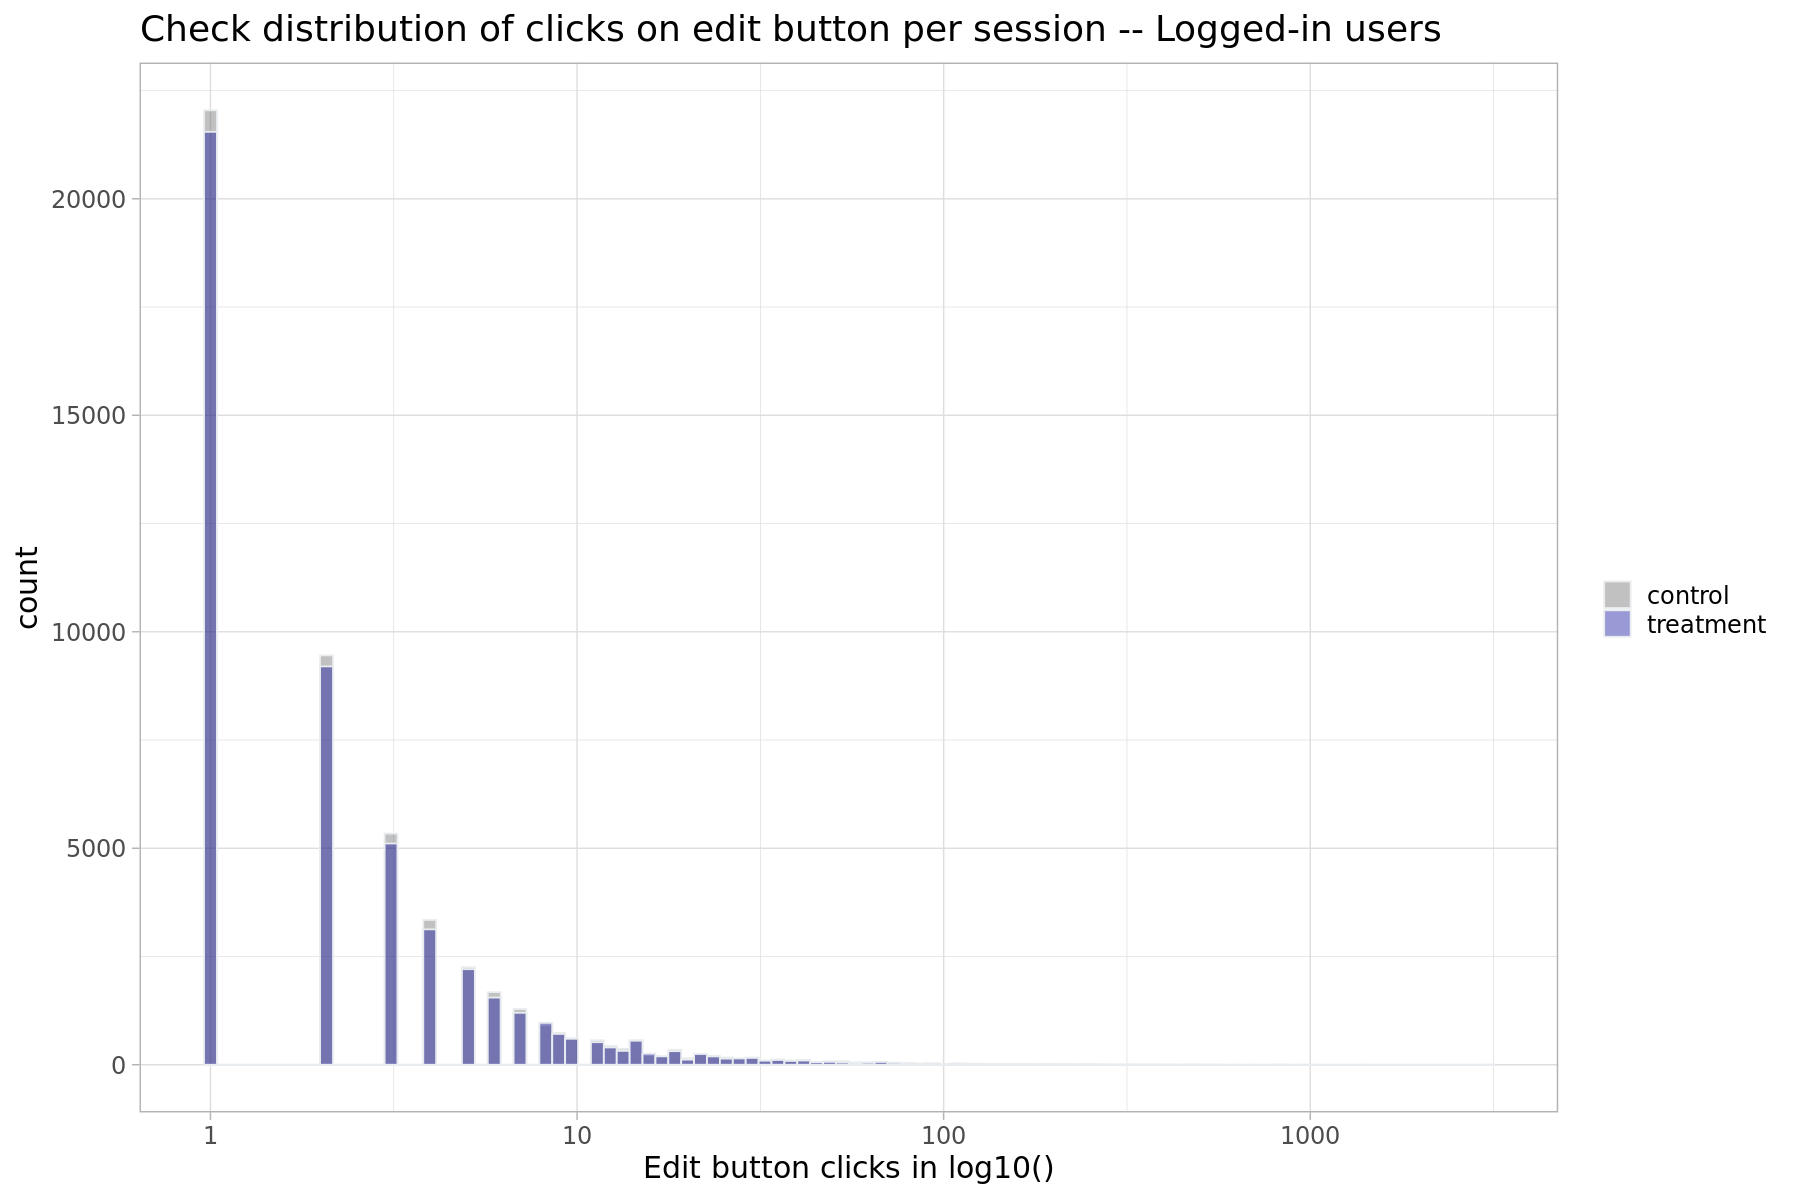

In [216]:
p1 <- df_edits_pvs_per_session %>%
 ggplot( aes(x=sum_edit_clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( x= "Edit button clicks in log10()", 
          title = "Check distribution of clicks on edit button per session -- Logged-in users",
         fill="") +
    theme_light(base_size=18)
p1

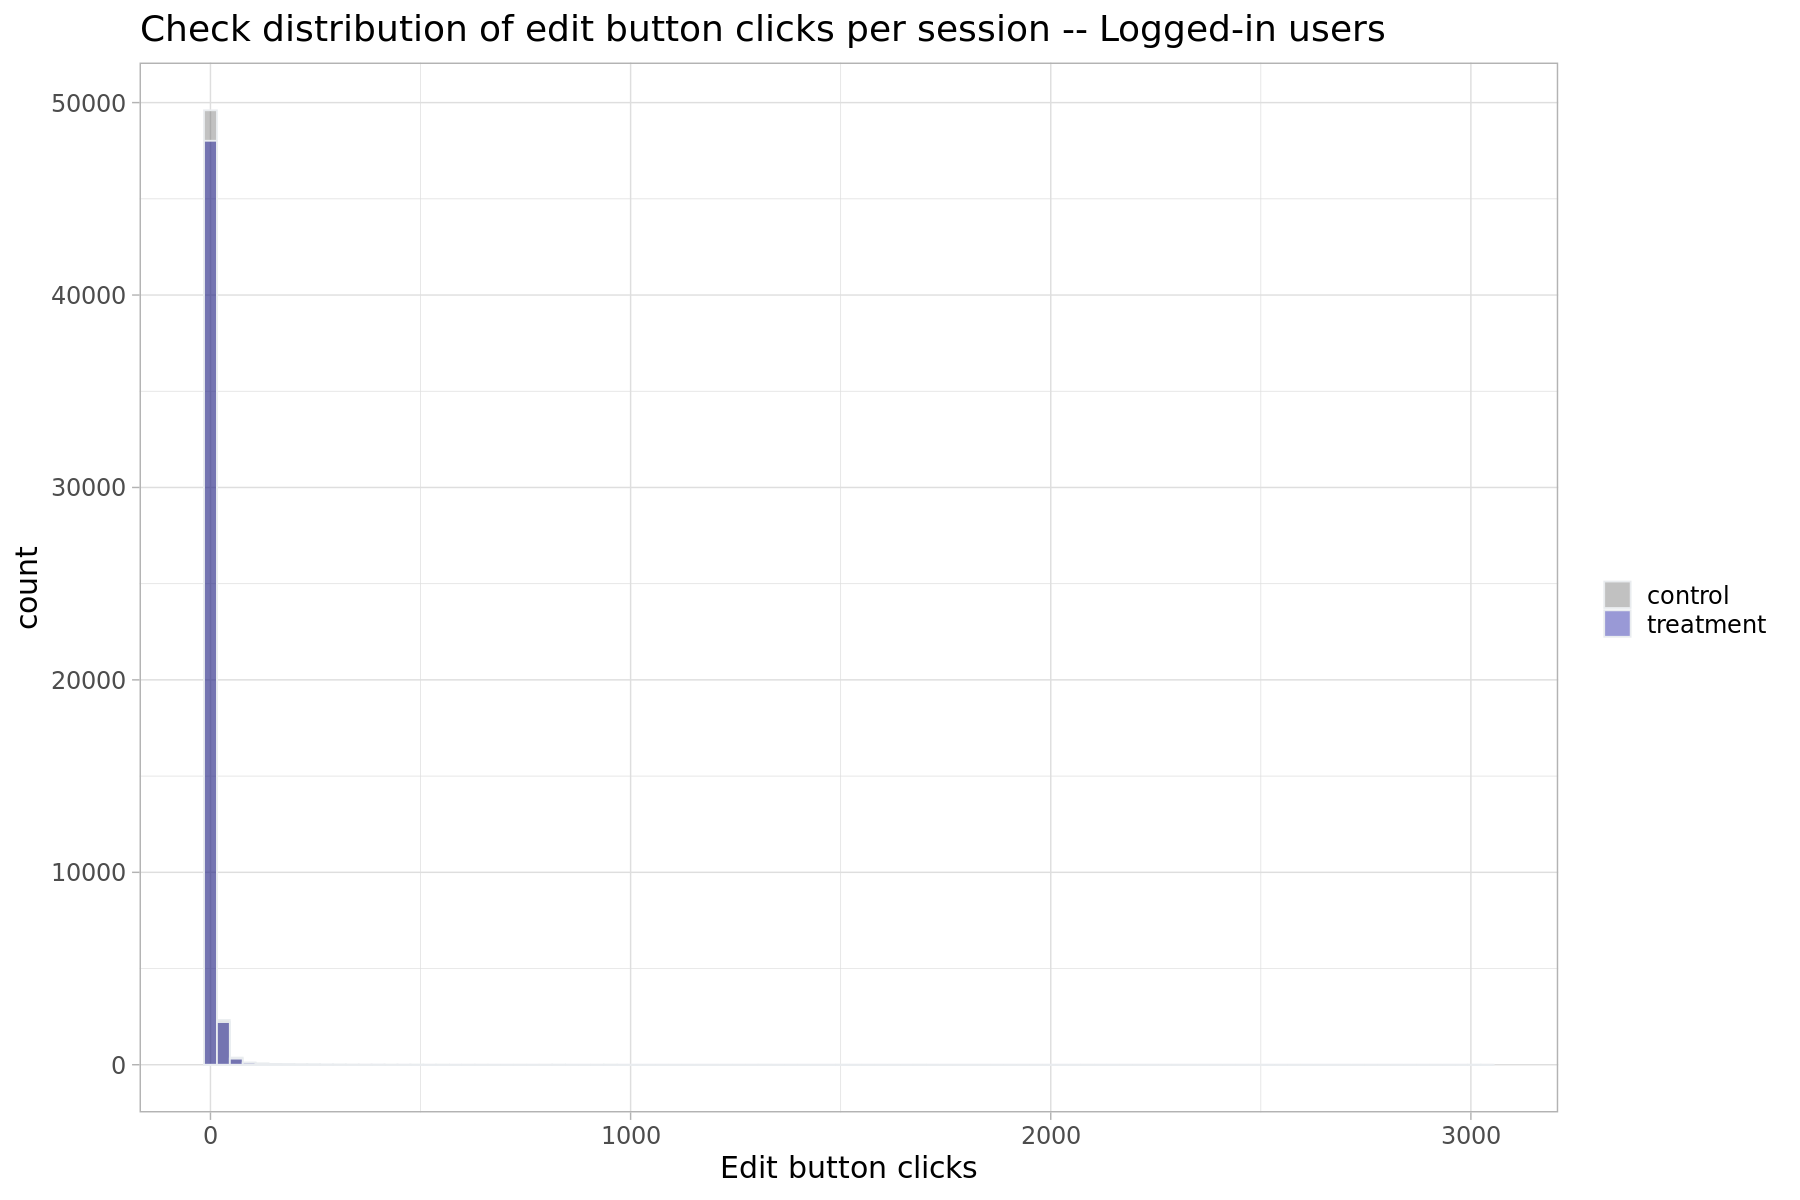

In [217]:
p2 <- df_edits_pvs_per_session %>%
 filter(sum_edit_clicks>0) %>%
 ggplot( aes(x=sum_edit_clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( x= "Edit button clicks", 
          title = "Check distribution of edit button clicks per session -- Logged-in users",
         fill="") +
    theme_light(base_size=18)
p2

In [213]:
nrow(df_edits_pvs_per_session[df_edits_pvs_per_session$sum_edit_clicks >= 30,])

[1] 2481

### Note
edit_clicks distribution is zero-inflated with a long right tail.

# Analysis
## By wiki

In [101]:
df_edits_pv_wiki <- df_edits_pvs_per_session %>% 
  group_by( wiki ,test_group) %>%
  summarize(total_pvs=sum(sum_pvs), total_pv_pages=sum(sum_pv_pages),
            total_edit_clicks=sum(sum_edit_clicks),
            n_sessions=n_distinct(session_id), ,.groups='drop') 

In [102]:
df_edits_pv_wiki <- df_edits_pv_wiki %>%
  mutate( edit_per_session =round( total_edit_clicks/n_sessions,4) ,
        edit_per_pv=round(total_edit_clicks/total_pvs,4)
        )

In [103]:
df_edits_pv_wiki

wiki,test_group,total_pvs,total_pv_pages,total_edit_clicks,n_sessions,edit_per_session,edit_per_pv
<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
enwiki,control,8032826,8031653,189010,451785,0.4184,0.0235
enwiki,treatment,7975065,7974056,183495,422227,0.4346,0.0230
fawiki,control,156055,155993,8631,9573,0.9016,0.0553
fawiki,treatment,125034,125000,5958,8954,0.6654,0.0477
frwiki,control,953480,953377,41496,55295,0.7504,0.0435
frwiki,treatment,925160,925046,39596,52465,0.7547,0.0428
hewiki,control,188825,188803,7714,9136,0.8444,0.0409
hewiki,treatment,195126,195085,9991,9777,1.0219,0.0512
kowiki,control,98851,98850,8010,4728,1.6942,0.0810


In [104]:
df_edits_pv_wiki %>% 
   group_by(test_group) %>%
   summarize(all_edit_clicks=sum(total_edit_clicks), all_pvs=sum(total_pvs), all_sessions=sum(n_sessions) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,287068,10056089,569972,0.5037,0.0285
treatment,272780,9868007,536839,0.5081,0.0276


In [105]:
0.0276/0.0285 - 1

[1] -0.03157895

In [106]:
0.5081/0.5037 -1

[1] 0.008735358

### Note

Edit is defined as the number of edit button clicks from logged-in desktop users.   
Edit attempt rate is defined as the total number of edit button clicks to the total number of pageviews from logged-in desktop users.

We observed an overall 0.87% increase in the edits per session (control 0.5037 ; treatment 0.5081, shown in below table) from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels. But noticed treatment groups have a lower proportion of sessions with 0 edits and fewer edits per session for those that made edits.


We observed a 3.2% decrease in edit rate (control 0.0285 ; treatment 0.0276, shown in below table) from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels.

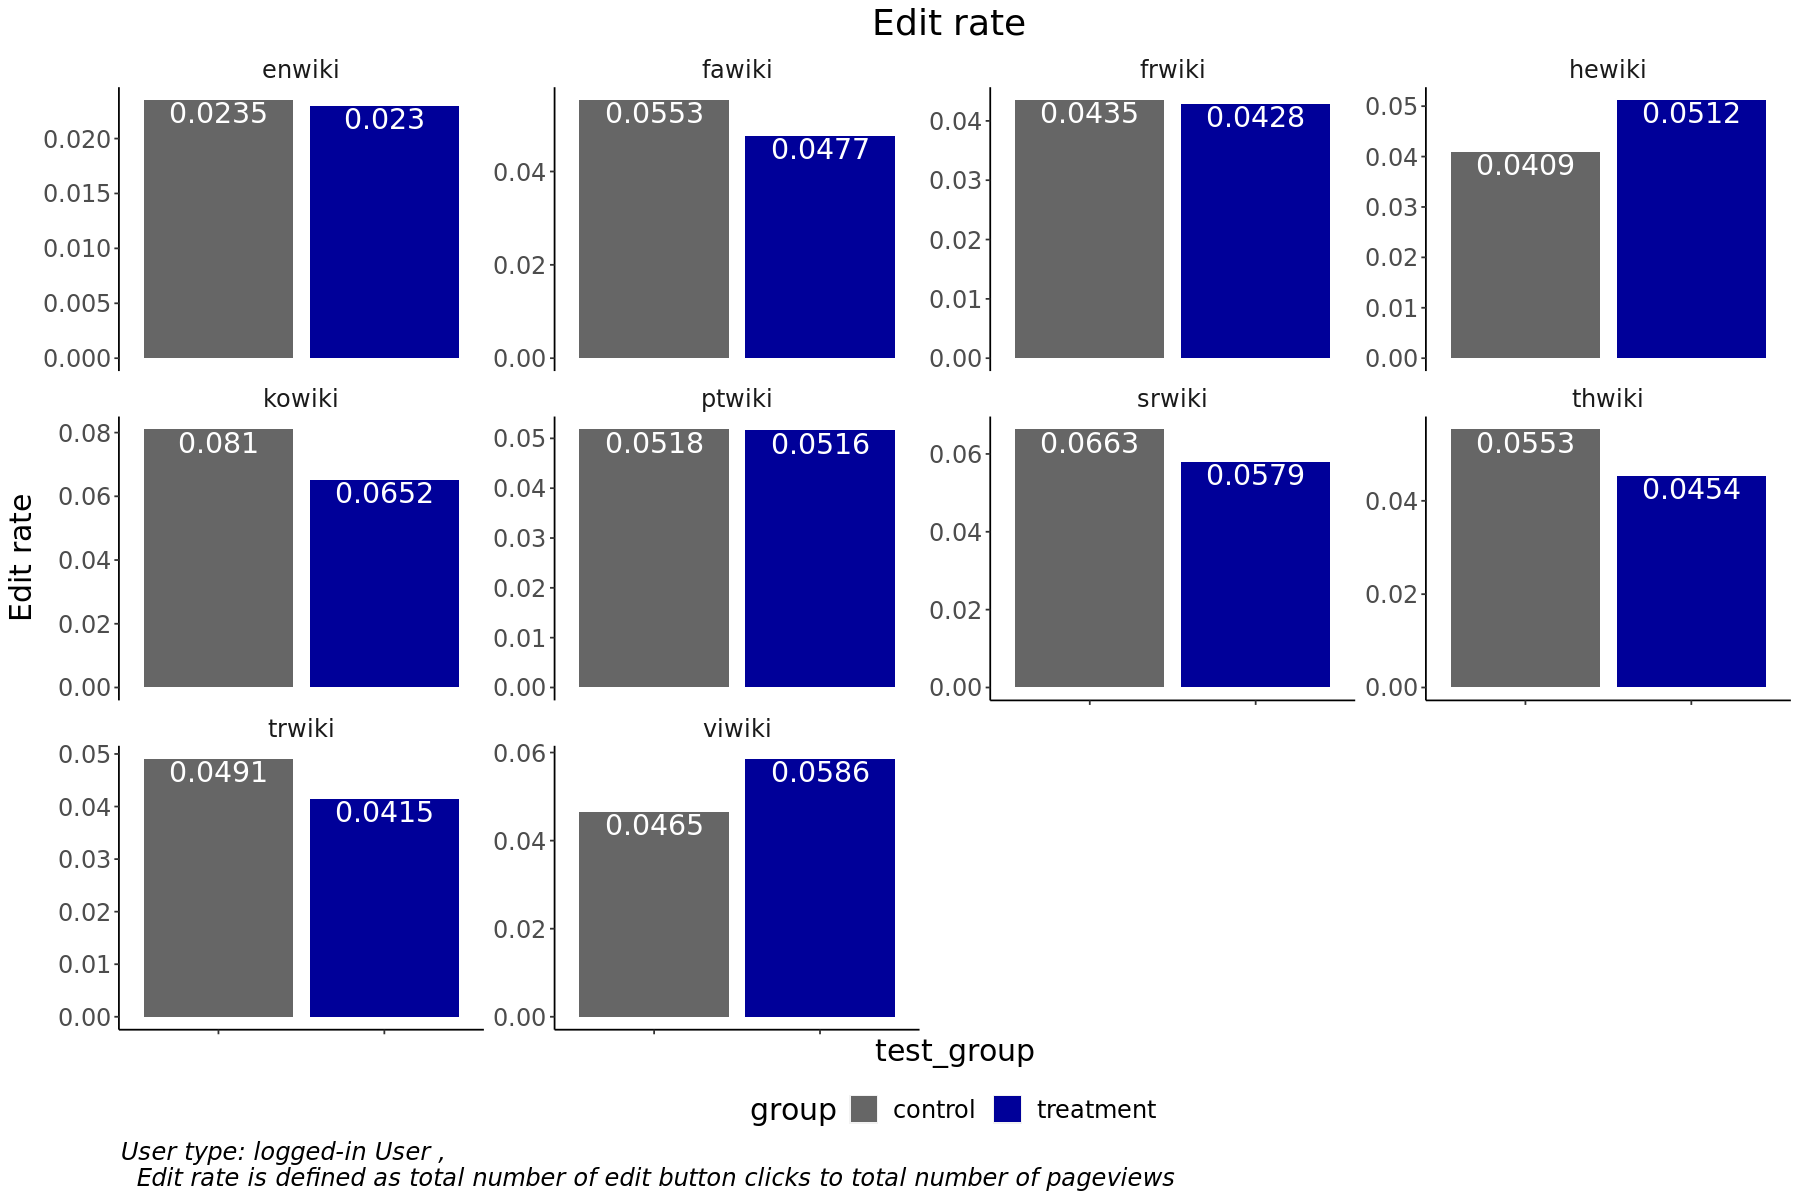

In [107]:
barchart_edits_per_pv  <- df_edits_pv_wiki  %>%
        select(wiki, test_group, edit_per_pv) %>%
        ggplot(aes(x = test_group, y= edit_per_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(edit_per_pv)), color = "white", position = position_dodge(width = 1), 
                  vjust =1.1, hjust = 0.5, size = 6) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Edit rate" ,
             title = "Edit rate " ,
             caption = "User type: logged-in User ,
  Edit rate is defined as total number of edit button clicks to total number of pageviews" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edits_per_pv

In [298]:
df_edits_pv_wiki  %>%
        select(wiki, test_group, edit_per_pv) %>%
        spread(test_group, edit_per_pv) %>%
        mutate(
            pct_change = round((treatment-control)/control * 100 , 2)
        )

wiki,control,treatment,pct_change
<chr>,<dbl>,<dbl>,<dbl>
enwiki,0.0235,0.0230,-2.13
fawiki,0.0553,0.0477,-13.74
frwiki,0.0435,0.0428,-1.61
hewiki,0.0409,0.0512,25.18
kowiki,0.0810,0.0652,-19.51
ptwiki,0.0518,0.0516,-0.39
srwiki,0.0663,0.0579,-12.67
thwiki,0.0553,0.0454,-17.90
trwiki,0.0491,0.0415,-15.48


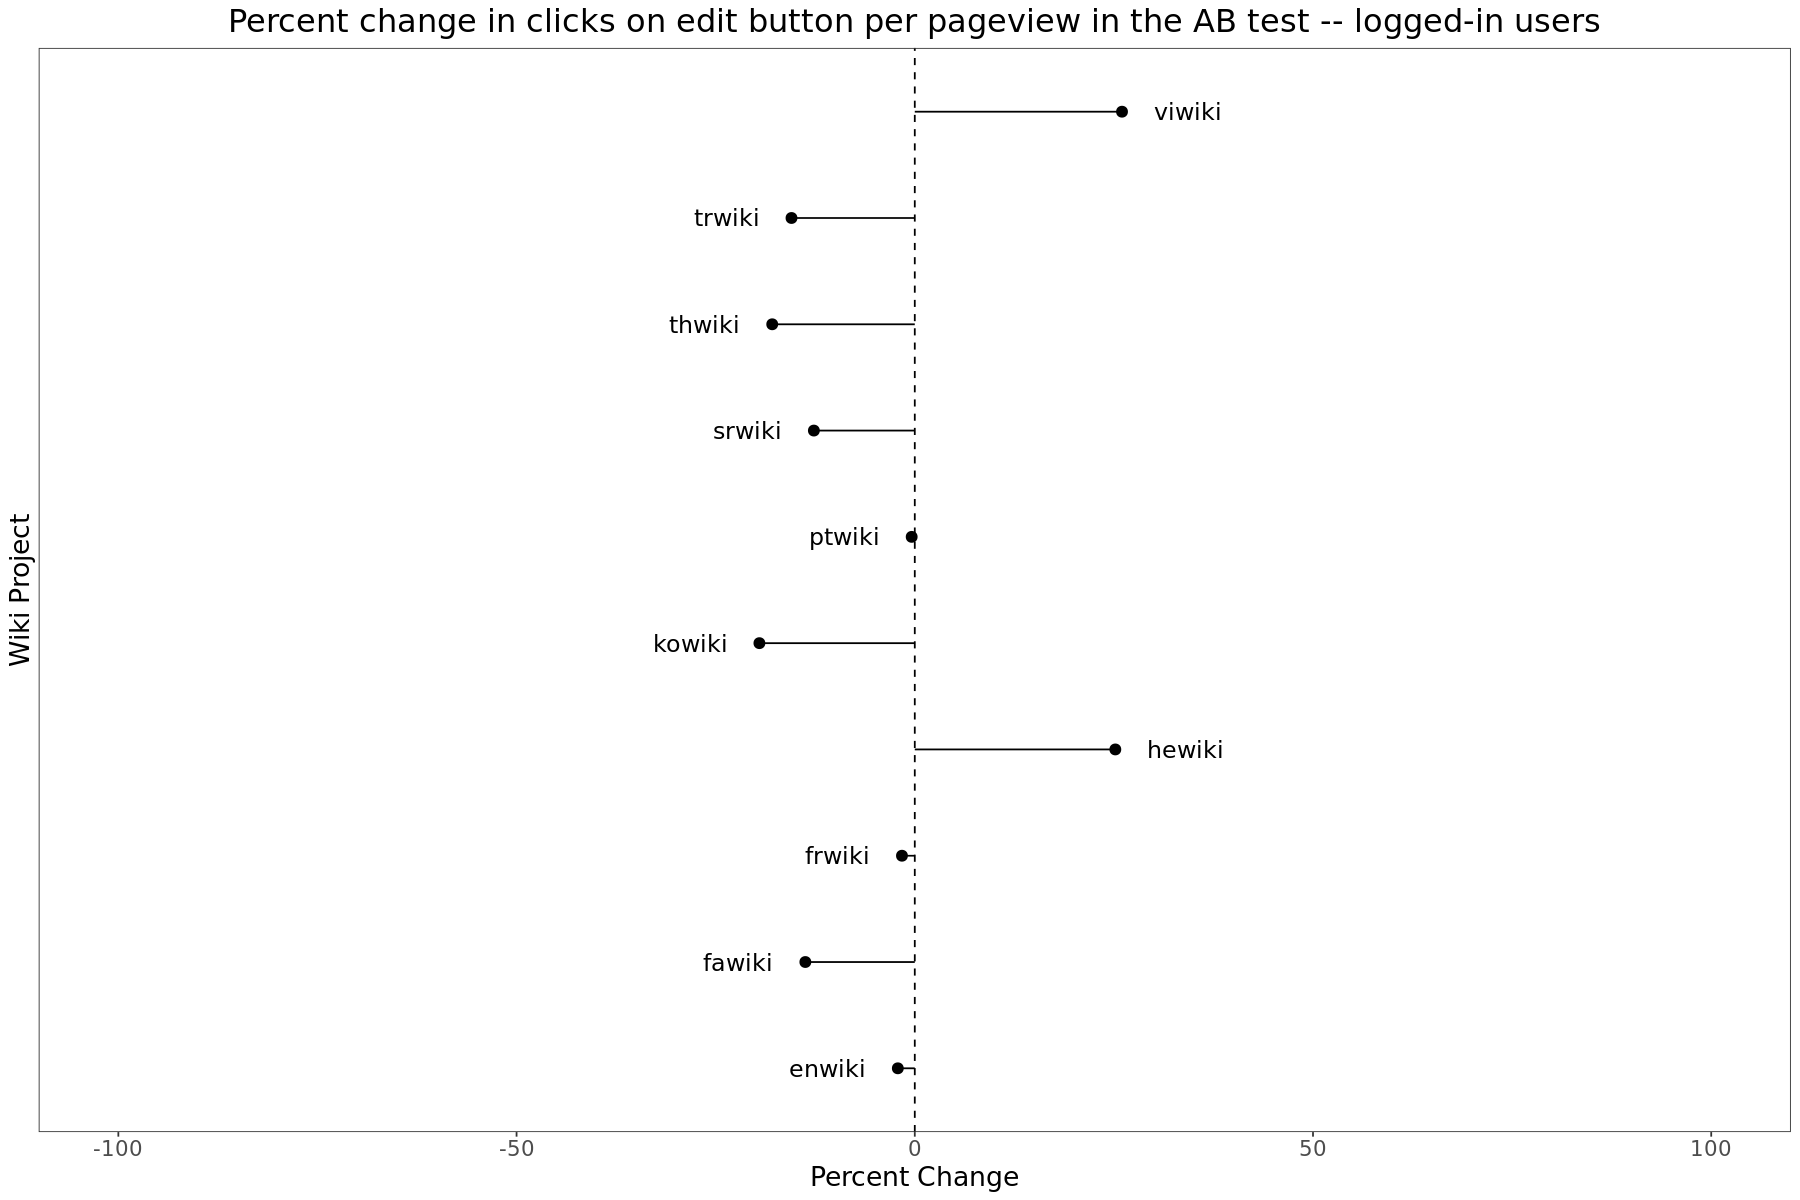

In [202]:
pct_g <- df_edits_pv_wiki  %>%
        select(wiki, test_group, edit_per_pv) %>%
        spread(test_group, edit_per_pv) %>%
        mutate(
            pct_change = round((treatment-control)/control * 100 , 2)
        ) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-100, 100)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in clicks on edit button per pageview in the AB test -- logged-in users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

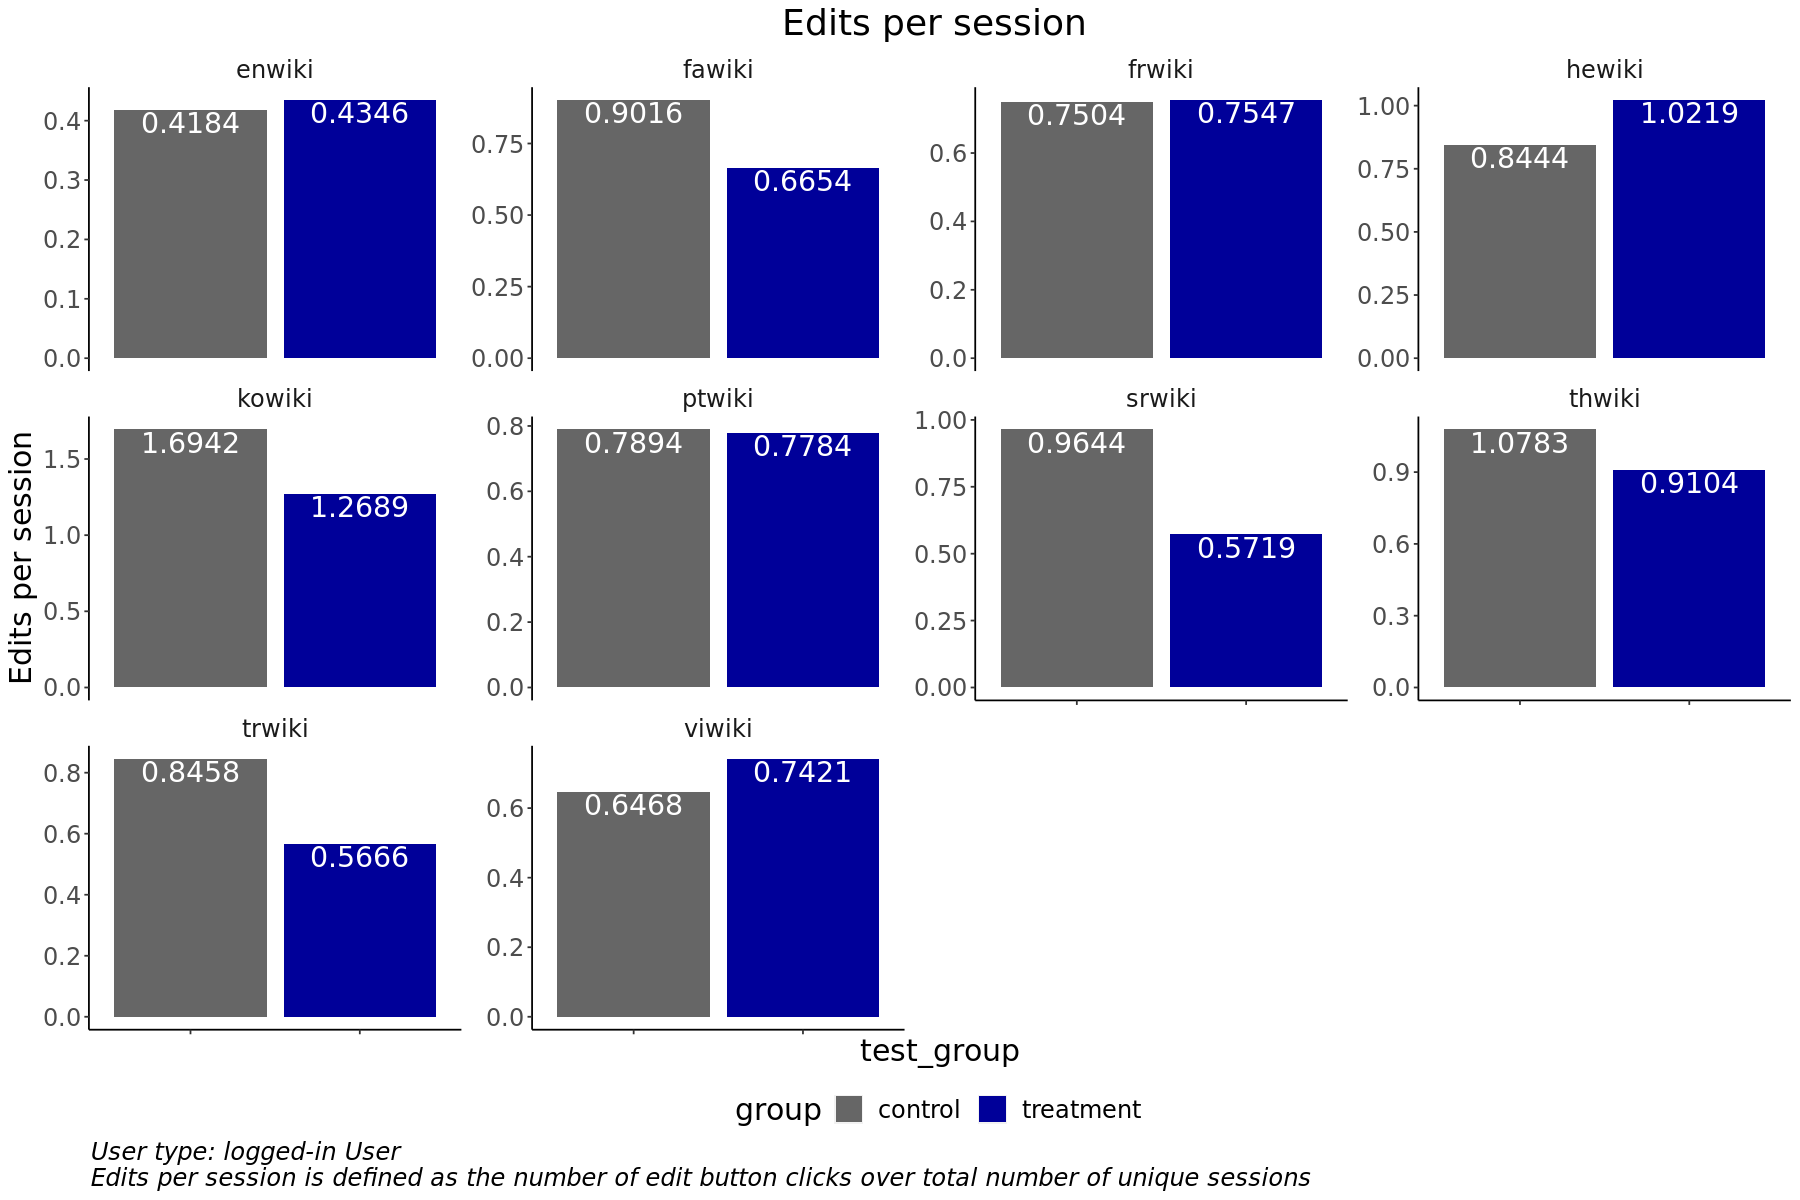

In [108]:
barchart_edits_per_session  <- df_edits_pv_wiki  %>%
        select(wiki, test_group, edit_per_session) %>%
        ggplot(aes(x = test_group, y= edit_per_session, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(edit_per_session)), color = "white", position = position_dodge(width = 1), 
                  vjust =1.1, hjust = 0.5, size = 6) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Edits per session" ,
             title = "Edits per session " ,
             caption = "User type: logged-in User 
Edits per session is defined as the number of edit button clicks over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edits_per_session

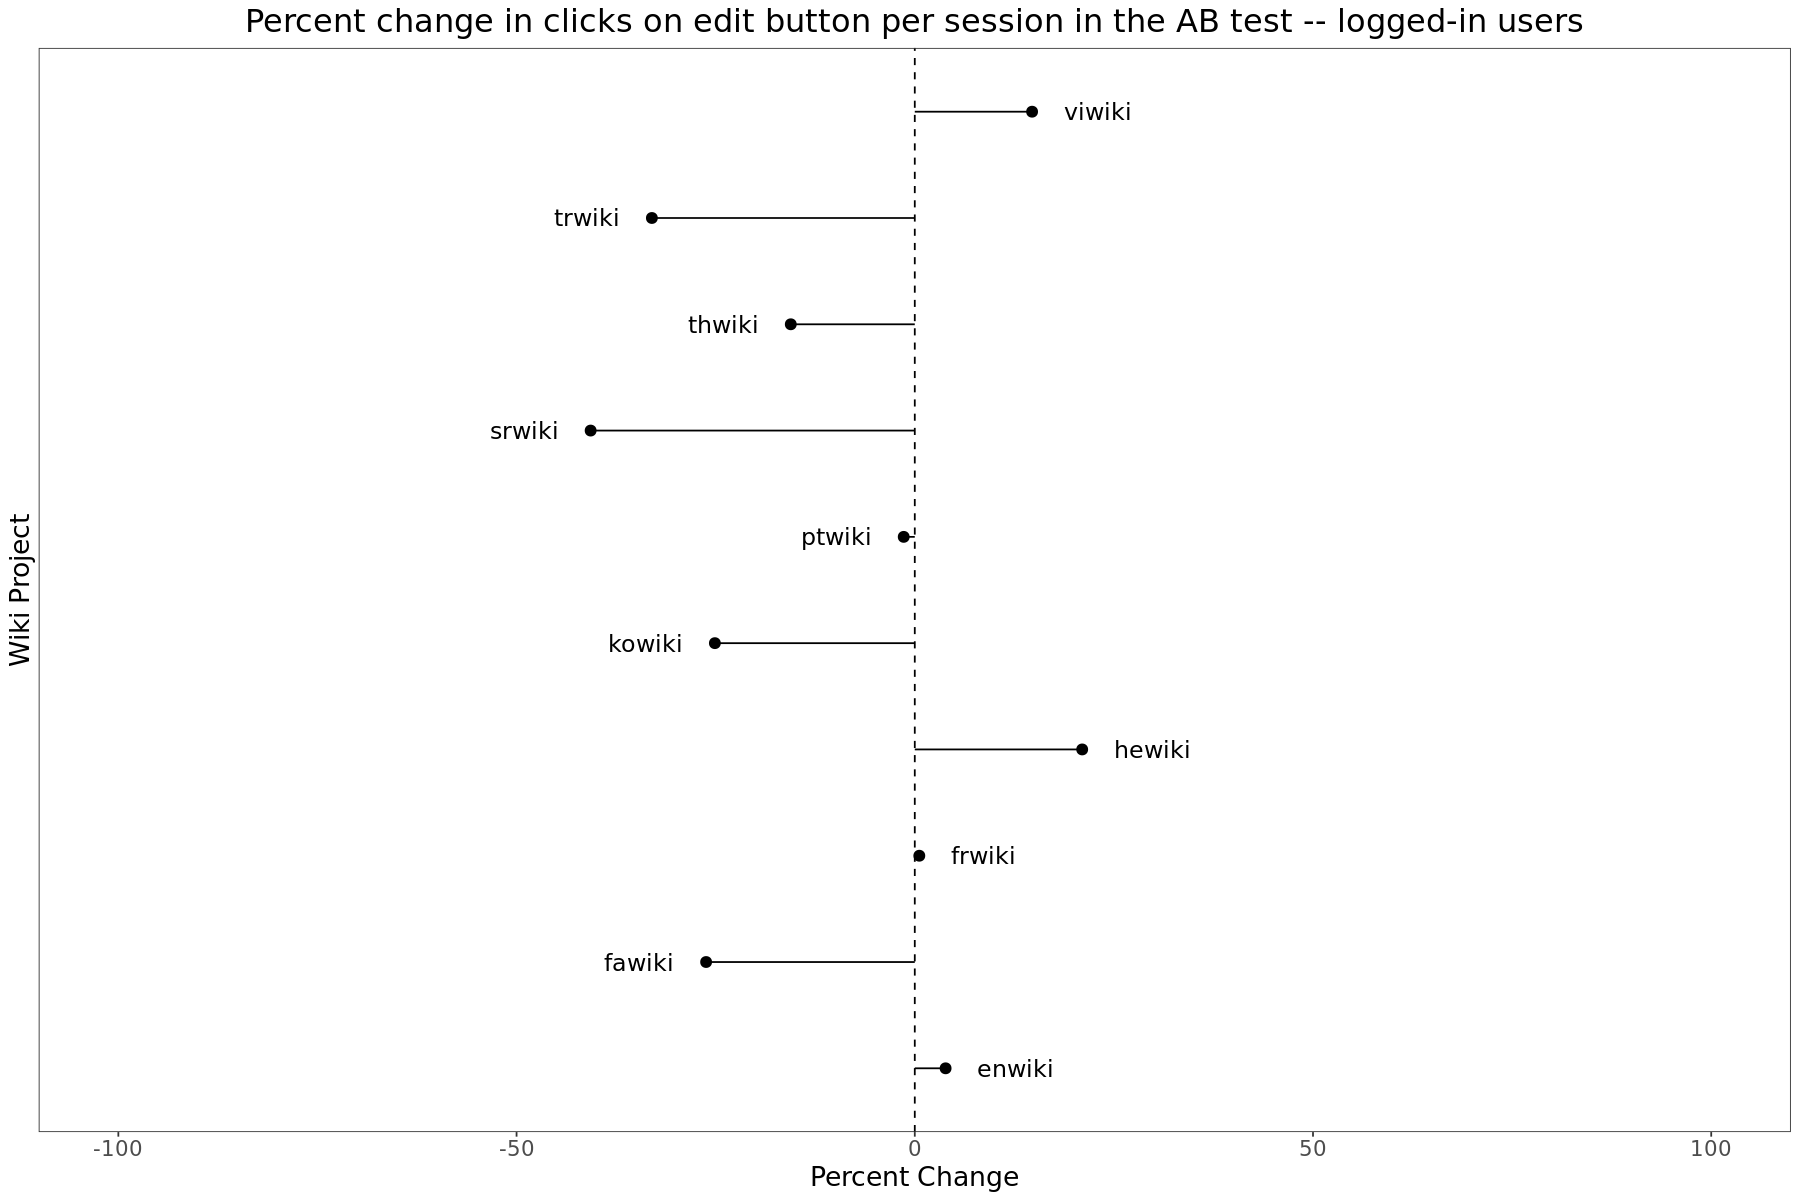

In [198]:
pct_g <- df_edits_pv_wiki  %>%
        select(wiki, test_group, edit_per_session) %>%
        spread(test_group, edit_per_session) %>%
        mutate(
            pct_change = round((treatment-control)/control * 100 , 2)
        ) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-100, 100)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in clicks on edit button per session in the AB test -- logged-in users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g
     

### Note 


When broken down by wiki, different trends were observed.
On 3 wikis, enwiki, hewiki, viwiki, the treatment group exhibited a higher number of edits per session compared to the control group. On 2 wikis, ptwiki and frwiki, the difference is close to 0. On 5 other wikis, the treatment group had a lower number of edits per session compared to the control group overall.

Regarding the edit rate,3 wikis (ptwiki, frwiki, enwiki) did not show a significant difference between treatment group and control group. 2 wikis (hewiki, viwiki) showed an increase in the treatment group, while 5 other wikis exhibited a decrease in the treatment group.



## By edit bucket

In [110]:
df_edit_pv %>% 
  group_by(session_id) %>%
  summarize(n_dup=n_distinct(editcountbucket), .groups='drop') %>%
  filter(n_dup>1) %>% 
  nrow()

[1] 19917

In [135]:
19917/1106811

[1] 0.01799494

__Note__
1.8% sessions switched editcountbucket during experiment

Will sessions swtiched editcountbucket on same page toake? No, return 0 session.



In [300]:
df_edit_pv %>% 
  group_by(session_id, page_token) %>%
  summarize(n_dup=n_distinct(editcountbucket), .groups='drop') %>%
  filter(n_dup>1) %>% 
  nrow()

[1] 0

In [114]:
df_switch_bucket <- df_edit_pv %>% 
  group_by(session_id) %>%
  summarize(n_dup=n_distinct(editcountbucket), .groups='drop') %>%
  filter(n_dup>1) %>%
  merge( df_edit_pv , by.x=c("session_id"), by.y=c("session_id")) %>%
  mutate(
      editcountbucket_lab = factor(
            editcountbucket , 
            levels = c("0 edits", "1-4 edits", "5-99 edits","100-999 edits", "1000+ edits")
              )
      ) %>%
  group_by(session_id,n_dup, wiki, test_group, editcountbucket_lab) %>%
  summarize(sum_edits=sum(edit_clicks), .groups='drop') %>%
  spread(key=editcountbucket_lab, value=sum_edits)

In [116]:
df_switch_bucket %>%
  filter( !is.na(df_switch_bucket[,c("100-999 edits")])& !is.na(df_switch_bucket[,c("1000+ edits")])) %>%
  nrow()

Warning message:
“Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead.”


[1] 147

Percentage of sessions switched from "100-999 edits" to "1000+ edits" during experiment.

In [117]:

147/19917 

[1] 0.00738063

In [118]:
df_switch_bucket %>%
  filter( !is.na(df_switch_bucket[,c("100-999 edits")])& !is.na(df_switch_bucket[,c("5-99 edits")])) %>%
  nrow()

[1] 586

Percentage of sessions switched from "5-99 edits" to  "100-999 edits" during experiment.

In [119]:
586/19917 

[1] 0.0294221

In [120]:
df_switch_bucket %>%
  filter( !is.na(df_switch_bucket[,c("1-4 edits")])& !is.na(df_switch_bucket[,c("5-99 edits")])) %>%
  nrow()

[1] 5470

Percentage of sessions switched from "1-4 edits" to "5-99 edits" during experiment.

In [121]:
5470/19917 

[1] 0.2746398

In [48]:
df_switch_bucket %>%
  filter( !is.na(df_switch_bucket[,c("1-4 edits")])& !is.na(df_switch_bucket[,c("0 edits")])) %>%
  nrow()

[1] 16016

Percentage of sessions switched from "0 eidts" to "1-4 edits" during experiment.

In [122]:
16016/19917 

[1] 0.8041372

Percentage of sessions in "0 eidts" , "1-4 edits", and "5-99 edits" groups during experiment.

In [123]:
df_switch_bucket %>%
  filter(is.na(df_switch_bucket[,c("100-999 edits")])& is.na(df_switch_bucket[,c("1000+ edits")]) )  %>%
  nrow()

[1] 19050

In [124]:
19050/19917 

[1] 0.9564693

In [125]:
df_switch_bucket %>%
  filter(!is.na(df_switch_bucket[,c("100-999 edits")])| !is.na(df_switch_bucket[,c("1000+ edits")]) )  %>%
  nrow()

[1] 867

In [126]:
df_switch_bucket %>%
  filter(!is.na(df_switch_bucket[,c("100-999 edits")])& !is.na(df_switch_bucket[,c("1000+ edits")]) )  %>%
  nrow()

[1] 147

### Note

19917 sessions (1.8% of total sessions) switched edit count bucket groups during AB test. 80% of these sessions transitioned from 0 edits group to 1-4 edits group. 95.6% of these sessions transitioned in 0 edits group, 1-4 edits group and 5-99 edits group. 

We will use the initial editcount bucket that the session was in as the edit count group for the following analysis and modeling. 

In [30]:
df_edits_pvs_bucket_per_session <- df_edit_pv %>% 
  mutate(
          editcountbucket_n = 
            case_when(
                editcountbucket == '0 edits' ~ 0 ,
                editcountbucket == '1-4 edits' ~ 4,
                editcountbucket == '5-99 edits' ~ 99,
                editcountbucket == '100-999 edits'  ~ 999,
                editcountbucket == '1000+ edits' ~ 1000,
                TRUE ~ NA
            )
        ) %>%
   group_by(session_id, wiki, test_group ) %>%
   summarize(sum_pvs=sum(pvs), sum_pv_pages=n_distinct(page_token),
             sum_edit_clicks=sum(edit_clicks), 
             editcountbucket_begin=min(editcountbucket_n),
             editcountbucket_end=max(editcountbucket_n),
             .groups='drop')

In [31]:
df_edits_pvs_bucket_per_session <- df_edits_pvs_bucket_per_session %>%
     mutate(
          editcountbucket_lab = factor(
            case_when(
                editcountbucket_begin == 0 ~ '0_edits'  ,
                editcountbucket_begin == 4 ~ '1_4_edits' ,
                editcountbucket_begin == 99 ~ '5_99_edits' ,
                editcountbucket_begin == 999 ~ '100_999_edits'  ,
                editcountbucket_begin == 1000 ~ '1000_more_edits',
                TRUE ~ 'others'
            ), levels = c('0_edits', '1_4_edits' ,'5_99_edits', '100_999_edits', '1000_more_edits', 'other')
          ) 
         )


In [207]:
df_edit_editbucket_overall <- df_edits_pvs_bucket_per_session %>%
   group_by(test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages), n_sessions=n_distinct(session_id), 
             total_edit_clicks=sum(sum_edit_clicks),
             .groups='drop') %>%
   mutate( edit_per_session =round( total_edit_clicks/n_sessions,4) ,
           edit_per_pv =round( total_edit_clicks/total_pvs,4)
            )
  

In [208]:
df_edit_editbucket_overall

test_group,editcountbucket_lab,total_pvs,total_pv_pages,n_sessions,total_edit_clicks,edit_per_session,edit_per_pv
<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
control,0_edits,1675249,1674933,186627,32539,0.1744,0.0194
control,1_4_edits,828957,828788,74938,11842,0.1580,0.0143
control,5_99_edits,2253880,2253578,150087,42524,0.2833,0.0189
control,100_999_edits,1686450,1686178,77818,43332,0.5568,0.0257
control,1000_more_edits,3611553,3611155,80502,156831,1.9482,0.0434
treatment,0_edits,1551263,1550968,153733,29565,0.1923,0.0191
treatment,1_4_edits,822927,822811,73213,12073,0.1649,0.0147
treatment,5_99_edits,2207717,2207439,152687,39694,0.2600,0.0180
treatment,100_999_edits,1750183,1749961,80104,39589,0.4942,0.0226


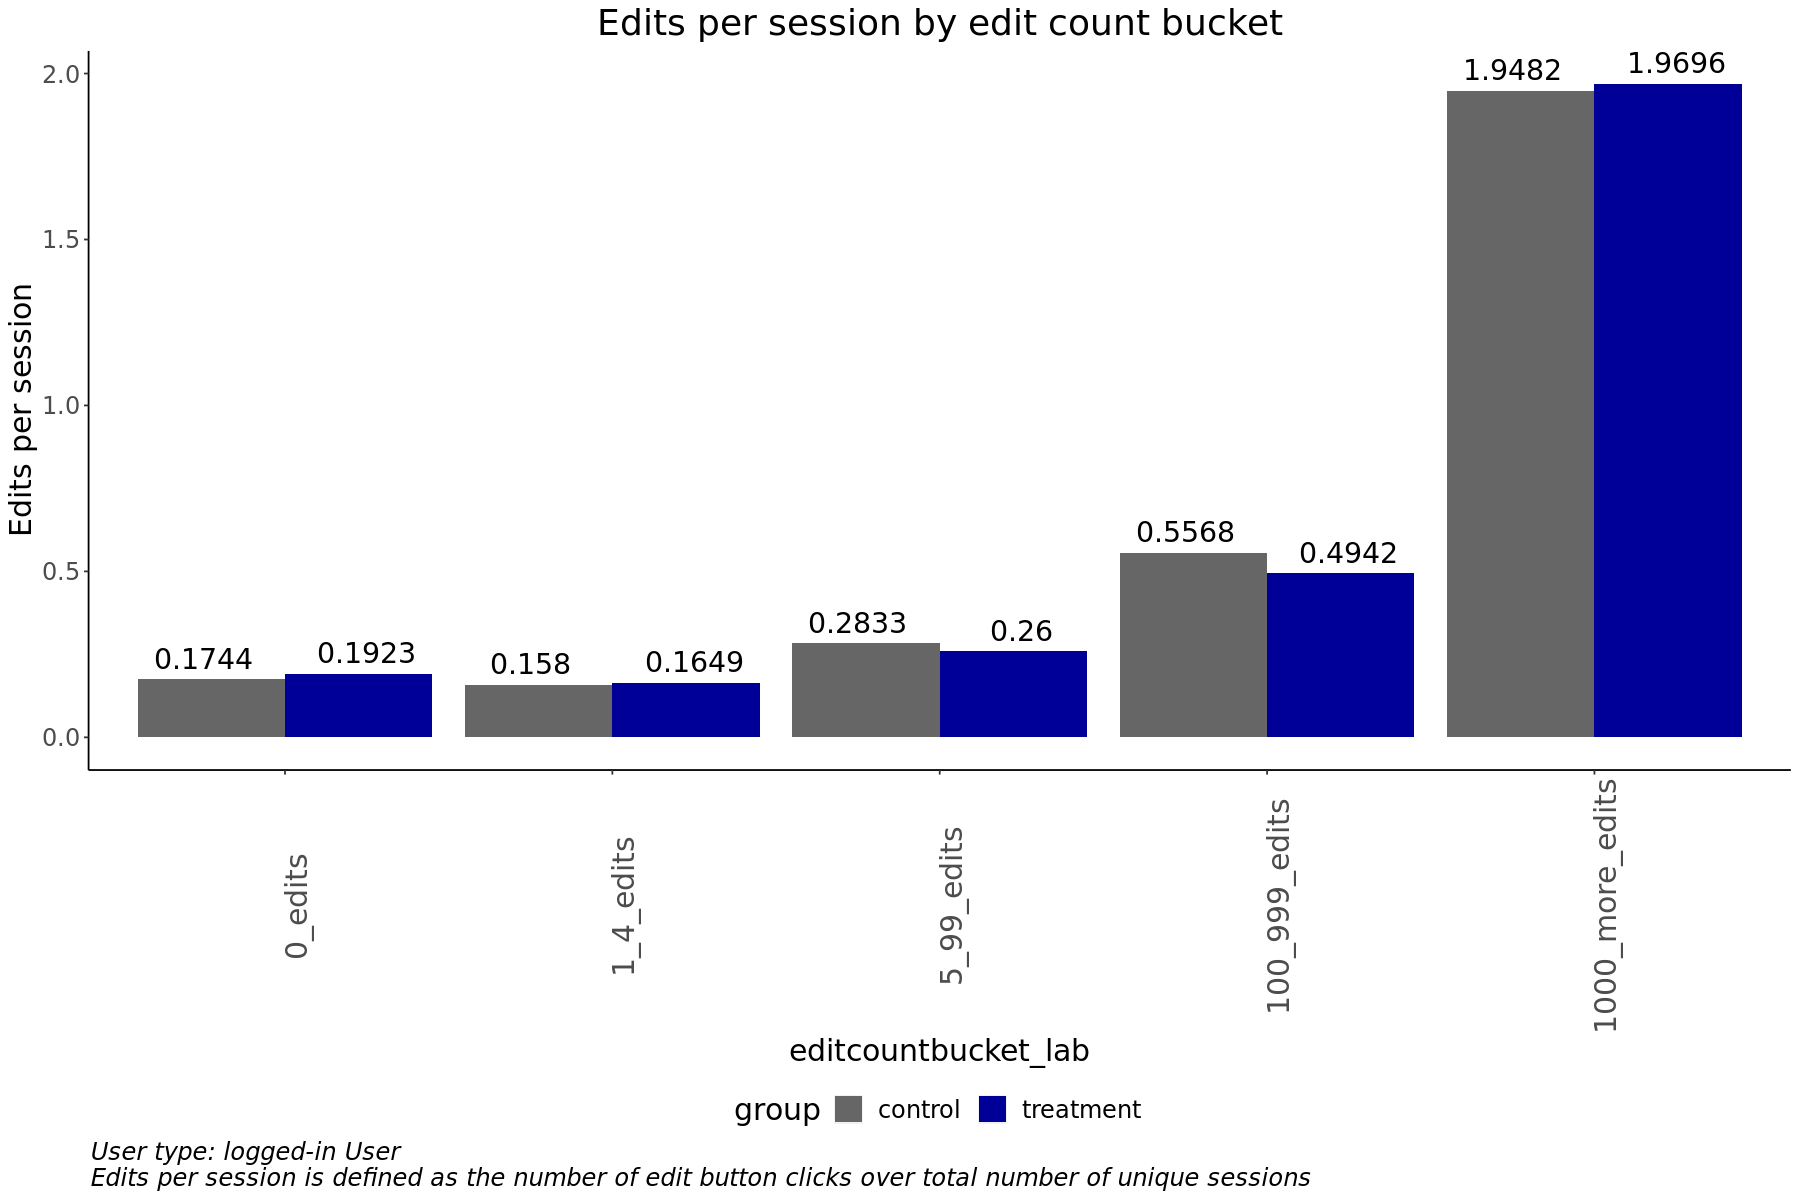

In [209]:
barchart_edit_editcountbucket_overall  <- df_edit_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= edit_per_session, fill=test_group)) +
        geom_text(aes(label = paste(edit_per_session)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "Edits per session" ,
             title = "Edits per session by edit count bucket" ,
             caption = "User type: logged-in User
Edits per session is defined as the number of edit button clicks over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edit_editcountbucket_overall

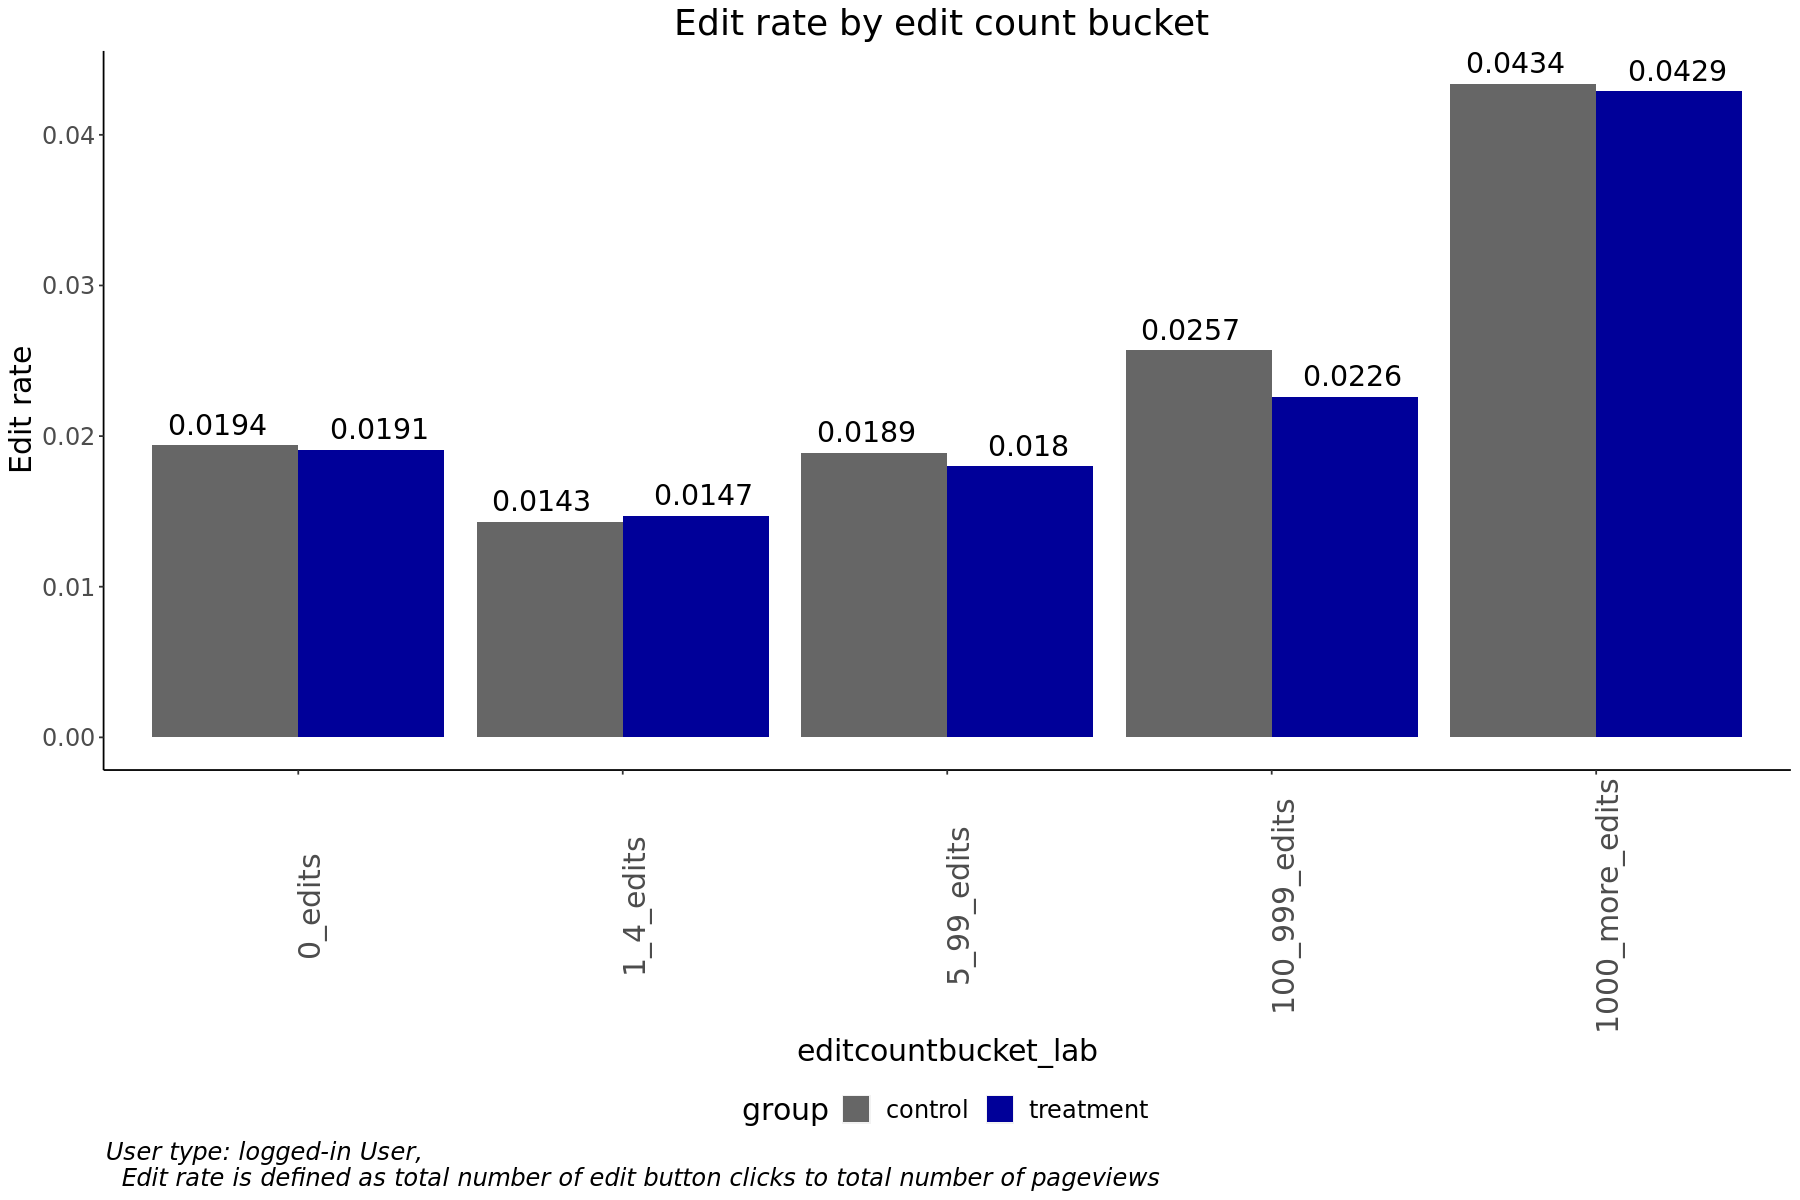

In [210]:
barchart_edit_rate_editcountbucket_overall  <- df_edit_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= edit_per_pv, fill=test_group)) +
        geom_text(aes(label = paste(edit_per_pv)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "Edit rate" ,
             title = "Edit rate by edit count bucket " ,
             caption = "User type: logged-in User,
  Edit rate is defined as total number of edit button clicks to total number of pageviews " ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edit_rate_editcountbucket_overall

### Note

When broken down by the editor's experience levels, different trends were observed.
We observed that the treatment group had fewer edits per session in 5-99 edits and '100-999 edits’ categories. However, in the “0 edits”, “1-4 edits” and ‘1000 or more edits’ categories, the treatment group demonstrates slightly more edits per session.

In terms of edit rate, it was generally lower in the treatment group across 4 edit count bucket groups, except for the “1-4 edits” group. The increase in pageviews did not result in the increase in edits.


## Modeling

In [136]:
head(df_edits_pvs_per_session)

session_id,wiki,test_group,sum_pvs,sum_pv_pages,sum_edit_clicks
<chr>,<chr>,<chr>,<int>,<int>,<dbl>
00002442139623d83906,ptwiki,control,37,36,2
0000379afc1707d74e0f,enwiki,treatment,9,9,0
00004cbb90f7494a16ba,frwiki,treatment,7,7,0
00005ca974dfda95fa33,enwiki,control,40,40,0
00007a37ee6f63eb17b3,enwiki,control,3,3,0
000082c303747a914740,enwiki,treatment,11,11,0


In [137]:
blas_set_num_threads(8)
m_6 <- glmmTMB( formula = sum_edit_clicks ~ test_group + (1 | wiki),
    ziformula= ~ test_group + (1 | wiki),       
    family = poisson(link = "identity"),
    data = df_edits_pvs_per_session)
blas_set_num_threads(1)

In [138]:
summary(m_6)

 Family: poisson  ( identity )
Formula:          sum_edit_clicks ~ test_group + (1 | wiki)
Zero inflation:                   ~test_group + (1 | wiki)
Data: df_edits_pvs_per_session

     AIC      BIC   logLik deviance df.resid 
 2321693  2321765 -1160841  2321681  1106805 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.8537   0.924   
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.06895  0.2626  
Number of obs: 1106811, groups:  wiki, 10

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          5.80250    0.29278  19.819  < 2e-16 ***
test_grouptreatment -0.09314    0.01454  -6.404 1.51e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          1.82235    0.08345  21.837  < 2e-16 ***
test_grouptreat

In [139]:
blas_set_num_threads(8)
m_7 <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+(1 | wiki),
    ziformula= ~ test_group +log(sum_pv_pages)+ (1 | wiki),       
    family = poisson(link = "identity"),
    data = df_edits_pvs_per_session)
blas_set_num_threads(1)


Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function evaluation”
Warning message in (function (start, objective, gradient = NULL, hessian = NULL, :
“NA/NaN function eval

In [140]:
summary(m_7)

 Family: poisson  ( identity )
Formula:          sum_edit_clicks ~ test_group + log(sum_pv_pages) + (1 | wiki)
Zero inflation:                   ~test_group + log(sum_pv_pages) + (1 | wiki)
Data: df_edits_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
1764434.7 1764530.0 -882209.3 1764418.7   1106803 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.004809 0.06935 
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1208   0.3476  
Number of obs: 1106811, groups:  wiki, 10

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.108809   0.023069     4.7 2.40e-06 ***
test_grouptreatment -0.008838   0.002122    -4.2 3.12e-05 ***
log(sum_pv_pages)    1.560533   0.002188   713.3  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                     E

In [141]:
head(df_edits_pvs_per_session)

session_id,wiki,test_group,sum_pvs,sum_pv_pages,sum_edit_clicks
<chr>,<chr>,<chr>,<int>,<int>,<dbl>
00002442139623d83906,ptwiki,control,37,36,2
0000379afc1707d74e0f,enwiki,treatment,9,9,0
00004cbb90f7494a16ba,frwiki,treatment,7,7,0
00005ca974dfda95fa33,enwiki,control,40,40,0
00007a37ee6f63eb17b3,enwiki,control,3,3,0
000082c303747a914740,enwiki,treatment,11,11,0


In [142]:
blas_set_num_threads(8)
m_8 <- glmmTMB( formula = sum_edit_clicks ~ test_group + sum_pv_pages +(1 | wiki),
    ziformula= ~ test_group + sum_pv_pages+ (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_per_session)
blas_set_num_threads(1)


In [143]:
summary(m_8)

 Family: nbinom2  ( log )
Formula:          sum_edit_clicks ~ test_group + sum_pv_pages + (1 | wiki)
Zero inflation:                   ~test_group + sum_pv_pages + (1 | wiki)
Data: df_edits_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
 928599.3  928706.5 -464290.6  928581.3   1106802 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.064    0.253   
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1092   0.3305  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.223 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -7.639e-02  8.117e-02   -0.94    0.347    
test_grouptreatment -5.713e-02  8.969e-03   -6.37  1.9e-10 ***
sum_pv_pages         9.114e-03  7.509e-05  121.38  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zer

In [214]:
blas_set_num_threads(8)
m_9 <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages) +(1 | wiki),
    ziformula= ~ test_group + log(sum_pv_pages)+ (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_per_session)
blas_set_num_threads(1)


In [215]:
summary(m_9)

 Family: nbinom2  ( log )
Formula:          sum_edit_clicks ~ test_group + log(sum_pv_pages) + (1 | wiki)
Zero inflation:                   ~test_group + log(sum_pv_pages) + (1 | wiki)
Data: df_edits_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
 893144.1  893251.4 -446563.1  893126.1   1106802 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.03476  0.1864  
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.184    0.429   
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.558 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.610590   0.062232  -41.95  < 2e-16 ***
test_grouptreatment -0.035732   0.009272   -3.85 0.000116 ***
log(sum_pv_pages)    0.954347   0.003907  244.26  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 

#### Add bucket level to modeling

In [37]:
blas_set_num_threads(8)
m_1 <- glmmTMB( formula = sum_edit_clicks ~ test_group + editcountbucket_lab +(1 | wiki),
    ziformula= ~ test_group + (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_bucket_per_session )
blas_set_num_threads(1)

In [38]:
summary(m_1)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + editcountbucket_lab + (1 | wiki)
Zero inflation:                   ~test_group + (1 | wiki)
Data: df_edits_pvs_bucket_per_session

      AIC       BIC    logLik  deviance  df.resid 
1113931.9 1114063.0 -556954.9 1113909.9   1106800 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.04934  0.2221  
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 61.88    7.866   
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.0648 

Conditional model:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -1.18565    0.07213  -16.44   <2e-16 ***
test_grouptreatment                -0.02224    0.01143   -1.95   0.0517 .  
editcountbucket_lab1_4_edits       -0.14345    0.01635   -8.77   <2e-16 ***
editcountbucket_la

In [147]:
blas_set_num_threads(8)
m_10 <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+editcountbucket_lab +(1 | wiki),
    ziformula= ~ test_group + log(sum_pv_pages)+ (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_bucket_per_session )
blas_set_num_threads(1)

In [148]:
summary(m_10)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + log(sum_pv_pages) + editcountbucket_lab +  
    (1 | wiki)
Zero inflation:                   ~test_group + log(sum_pv_pages) + (1 | wiki)
Data: df_edits_pvs_bucket_per_session

      AIC       BIC    logLik  deviance  df.resid 
 892310.6  892465.5 -446142.3  892284.6   1106798 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.04028  0.2007  
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1908   0.4369  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.484 

Conditional model:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.682290   0.067075  -39.99  < 2e-16 ***
test_grouptreatment                -0.032234   0.009633   -3.35 0.000819 ***
log(sum_pv_pages)                   0.925303  

In [218]:
blas_set_num_threads(8)
m_11 <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+editcountbucket_lab +(1 | wiki),
    ziformula= ~ test_group + log(sum_pv_pages)+editcountbucket_lab + (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_bucket_per_session )
blas_set_num_threads(1)

In [219]:
summary(m_11)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + log(sum_pv_pages) + editcountbucket_lab +  
    (1 | wiki)
Zero inflation:                   
~test_group + log(sum_pv_pages) + editcountbucket_lab + (1 |     wiki)
Data: df_edits_pvs_bucket_per_session

      AIC       BIC    logLik  deviance  df.resid 
 886483.3  886685.8 -443224.6  886449.3   1106794 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.0304   0.1744  
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1753   0.4186  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.639 

Conditional model:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.707787   0.059410  -45.58  < 2e-16 ***
test_grouptreatment                -0.036607   0.008701   -4.21 2.59e-05 ***
log(sum_pv_pages)  

In [221]:
blas_set_num_threads(8)
m_12 <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+editcountbucket_lab +(1 | wiki) +(1|editcountbucket_lab),
    ziformula= ~ test_group + log(sum_pv_pages)+editcountbucket_lab + (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_bucket_per_session )
blas_set_num_threads(1)

In [222]:
summary(m_12)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + log(sum_pv_pages) + editcountbucket_lab +  
    (1 | wiki) + (1 | editcountbucket_lab)
Zero inflation:                   
~test_group + log(sum_pv_pages) + editcountbucket_lab + (1 |     wiki)
Data: df_edits_pvs_bucket_per_session

      AIC       BIC    logLik  deviance  df.resid 
 886485.3  886699.8 -443224.6  886449.3   1106793 

Random effects:

Conditional model:
 Groups              Name        Variance  Std.Dev. 
 wiki                (Intercept) 3.040e-02 1.744e-01
 editcountbucket_lab (Intercept) 1.483e-09 3.851e-05
Number of obs: 1106811, groups:  wiki, 10; editcountbucket_lab, 5

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1752   0.4186  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.639 

Conditional model:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.

In [151]:
r.squaredGLMM(m_10) 

Warning message in r.squaredGLMM.glmmTMB(m_10):
“the effects of zero-inflation and dispersion model are ignored”
Warning message:
“the null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.4207460,0.4303193
lognormal,0.5835893,0.5968678
trigamma,0.2067038,0.2114070


In [220]:
r.squaredGLMM(m_11) 

Warning message in r.squaredGLMM.glmmTMB(m_11):
“the effects of zero-inflation and dispersion model are ignored”
Warning message:
“the null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.5115378,0.5192677
lognormal,0.6482008,0.6579959
trigamma,0.3081682,0.3128250


In [223]:
r.squaredGLMM(m_12) 

Warning message in r.squaredGLMM.glmmTMB(m_12):
“the effects of zero-inflation and dispersion model are ignored”
Warning message:
“the null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.5032469,0.5108517
lognormal,0.6436042,0.6533300
trigamma,0.2962232,0.3006996


### Note
Choose m_11 model based on the lower AIC and higher R-squared. 

No improvement from m_11 to m_12.

### Estimate the impact

In [224]:
fixef(m_11)


Conditional model:
                       (Intercept)                 test_grouptreatment  
                          -2.70779                            -0.03661  
                 log(sum_pv_pages)        editcountbucket_lab1_4_edits  
                           1.02241                             0.03768  
     editcountbucket_lab5_99_edits    editcountbucket_lab100_999_edits  
                           0.07280                            -0.09595  
editcountbucket_lab1000_more_edits  
                          -0.26425  

Zero-inflation model:
                       (Intercept)                 test_grouptreatment  
                           1.32166                             0.00634  
                 log(sum_pv_pages)        editcountbucket_lab1_4_edits  
                          -0.46193                             0.23808  
     editcountbucket_lab5_99_edits    editcountbucket_lab100_999_edits  
                          -0.00380                            -0.41008  
editcou

Count model interpretation

In [225]:
exp(-0.03661)

[1] 0.964052

In [226]:
1-exp(-0.03661)

[1] 0.03594796

Assigning to treatment group decreased the edits per session by 3.595%. (close to the result of m_pscl_1: 3.71129%)

In [248]:
exp(0.006340)

[1] 1.00636

The odds of 0 edit is increased by assiging to treatment group by 0.636% (close to the result of m_pscl_1: 0.63334%). But the impact is not statistically significant( p-value= 0.617 >0.05).


In [284]:
summary(m_11)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + log(sum_pv_pages) + editcountbucket_lab +  
    (1 | wiki)
Zero inflation:                   
~test_group + log(sum_pv_pages) + editcountbucket_lab + (1 |     wiki)
Data: df_edits_pvs_bucket_per_session

      AIC       BIC    logLik  deviance  df.resid 
 886483.3  886685.8 -443224.6  886449.3   1106794 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.0304   0.1744  
Number of obs: 1106811, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.1753   0.4186  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.639 

Conditional model:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.707787   0.059410  -45.58  < 2e-16 ***
test_grouptreatment                -0.036607   0.008701   -4.21 2.59e-05 ***
log(sum_pv_pages)  

### Conclusion
p-value = 2.59e-05 (< 0.05); coefficient of test_grouptreatment is -0.036607 < 0. 

It means that modeling using the session based data estimated that a 3.595% __decrease__ in edit button clicks per session in the treatment group was attributed to the new page separation.


# Deep dive for curiosity

## Check 0 and non-0 proportion

In [243]:
df_edits_pvs_bucket_per_session %>%
     group_by(test_group) %>%
   summarize(all_edit_clicks=sum(sum_edit_clicks), all_pvs=sum(sum_pvs), 
             all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,287068,10056089,569972,0.5037,0.0285
treatment,272780,9868007,536839,0.5081,0.0276


In [239]:
df_edits_pvs_bucket_per_session %>%
  filter(sum_edit_clicks < 80 ) %>%
     group_by(test_group) %>%
   summarize(all_edit_clicks=sum(sum_edit_clicks), all_pvs=sum(sum_pvs), 
             all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,226294,9490903,569668,0.3972,0.0238
treatment,214505,9300101,536540,0.3998,0.0231


In [240]:
df_edits_pvs_bucket_per_session %>%
  filter(sum_edit_clicks >= 80) %>%
   nrow()

[1] 603

In [241]:
df_edits_pvs_bucket_per_session %>%
  filter(sum_edit_clicks > 0 ) %>%
     group_by(test_group) %>%
   summarize(all_edit_clicks=sum(sum_edit_clicks), all_pvs=sum(sum_pvs), 
             all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,287068,4504622,52620,5.4555,0.0637
treatment,272780,4350516,50870,5.3623,0.0627


In [242]:
df_edits_pvs_bucket_per_session %>%
  filter(sum_edit_clicks == 0 ) %>%
     group_by(test_group) %>%
   summarize(all_edit_clicks=sum(sum_edit_clicks), all_pvs=sum(sum_pvs), 
             all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,0,5551467,517352,0,0
treatment,0,5517491,485969,0,0


## Run modeling with pscl, got an estimation close to m_11

In [244]:
library(pscl)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis



In [250]:
blas_set_num_threads(8)
m_pscl_1 <- zeroinfl(formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+editcountbucket_lab,
                                 dist    = "negbin",
                                 data    = df_edits_pvs_bucket_per_session)
blas_set_num_threads(1)

In [251]:
summary(m_pscl_1)


Call:
zeroinfl(formula = sum_edit_clicks ~ test_group + log(sum_pv_pages) + 
    editcountbucket_lab, data = df_edits_pvs_bucket_per_session, dist = "negbin")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -0.73999  -0.24998  -0.14328  -0.07689 200.41179 

Count model coefficients (negbin with log link):
                                    Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                        -2.954137   0.021806 -135.476  < 2e-16 ***
test_grouptreatment                -0.037819   0.008865   -4.266 1.99e-05 ***
log(sum_pv_pages)                   1.015934   0.004606  220.582  < 2e-16 ***
editcountbucket_lab1_4_edits        0.054147   0.020389    2.656  0.00791 ** 
editcountbucket_lab5_99_edits       0.084525   0.014646    5.771 7.88e-09 ***
editcountbucket_lab100_999_edits   -0.099594   0.015407   -6.464 1.02e-10 ***
editcountbucket_lab1000_more_edits -0.223574   0.013814  -16.184  < 2e-16 ***
Log(theta)                         -0.522232

In [265]:
expCoef <- exp(coef((m_pscl_1)))
expCoef <- matrix(expCoef, ncol = 2)

In [268]:
expCoef

0.0521236,7.1417335
0.9628871,1.0063334
2.7619414,0.6393393
1.0556403,1.2677952
1.0882004,0.9884765
0.9052051,0.6529024
0.7996556,0.2442707


In [270]:
colnames(expCoef) <- c("Count_model","Zero_hurdle_model")

In [273]:
names(m_pscl_1)

[1] "coefficients"  "residuals"     "fitted.values" "optim"        
 [5] "method"        "control"       "start"         "weights"      
 [9] "offset"        "n"             "df.null"       "df.residual"  
[13] "terms"         "theta"         "SE.logtheta"   "loglik"       
[17] "vcov"          "dist"          "link"          "linkinv"      
[21] "converged"     "call"          "formula"       "levels"       
[25] "contrasts"     "model"         "y"

In [276]:
names(coef(m_pscl_1))

[1] "count_(Intercept)"                       
 [2] "count_test_grouptreatment"               
 [3] "count_log(sum_pv_pages)"                 
 [4] "count_editcountbucket_lab1_4_edits"      
 [5] "count_editcountbucket_lab5_99_edits"     
 [6] "count_editcountbucket_lab100_999_edits"  
 [7] "count_editcountbucket_lab1000_more_edits"
 [8] "zero_(Intercept)"                        
 [9] "zero_test_grouptreatment"                
[10] "zero_log(sum_pv_pages)"                  
[11] "zero_editcountbucket_lab1_4_edits"       
[12] "zero_editcountbucket_lab5_99_edits"      
[13] "zero_editcountbucket_lab100_999_edits"   
[14] "zero_editcountbucket_lab1000_more_edits"

In [277]:
rownames(expCoef) <- c("Intercept","test_grouptreatment","log(sum_pv_pages)", "count_editcountbucket_lab1_4_edits"
                      , "count_editcountbucket_lab5_99_edits" ,"count_editcountbucket_lab100_999_edits" ,"count_editcountbucket_lab1000_more_edits")

In [278]:
expCoef

,Count_model,Zero_hurdle_model
Intercept,0.0521236,7.1417335
test_grouptreatment,0.9628871,1.0063334
log(sum_pv_pages),2.7619414,0.6393393
count_editcountbucket_lab1_4_edits,1.0556403,1.2677952
count_editcountbucket_lab5_99_edits,1.0882004,0.9884765
count_editcountbucket_lab100_999_edits,0.9052051,0.6529024
count_editcountbucket_lab1000_more_edits,0.7996556,0.2442707


In [279]:
1-0.9628871

[1] 0.0371129

Interpretation: (Zero-inflation model) The baseline odds of having 0 edit per session over odds of >0 edit is 7.1417335:1 . The odds is increased by assiging to treatment group by 0.63334%. (p-value=0.619)

(Count model) Edit per session is decreased by assigning to treatment group by 3.71129%. 



ref:https://rpubs.com/kaz_yos/pscl-2

## Rerun model by excluding top outliners, estimation is close to the result of m_11

In [286]:
summary(df_edits_pvs_bucket_per_session)

  session_id            wiki            test_group           sum_pvs     
 Length:1106811     Length:1106811     Length:1106811     Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    1  
 Mode  :character   Mode  :character   Mode  :character   Median :    4  
                                                          Mean   :   18  
                                                          3rd Qu.:   11  
                                                          Max.   :31002  
  sum_pv_pages   sum_edit_clicks     editcountbucket_begin editcountbucket_end
 Min.   :    1   Min.   :   0.0000   Min.   :   0.0        Min.   :   0.0     
 1st Qu.:    1   1st Qu.:   0.0000   1st Qu.:   0.0        1st Qu.:   0.0     
 Median :    4   Median :   0.0000   Median :  99.0        Median :  99.0     
 Mean   :   18   Mean   :   0.5058   Mean   : 312.6        Mean   : 313.7     
 3rd Qu.:   11   3rd Qu.:   0.0000   3rd Qu.: 999.0        3rd Qu.: 999.0     
 Max.   

In [294]:
df_edits_pvs_bucket_per_session %>%
   filter(sum_edit_clicks > 100 ) %>%
   group_by(test_group)  %>%
   summarize(all_sessions=n_distinct(session_id) , .groups='drop')

test_group,all_sessions
<chr>,<int>
control,230
treatment,222


In [292]:
df_edits_pvs_bucket_per_session_cap <- df_edits_pvs_bucket_per_session %>%
   filter(sum_edit_clicks <=100 )

In [293]:
df_edits_pvs_bucket_per_session_cap  %>% 
   group_by(test_group) %>%
   summarize(all_edit_clicks=sum(sum_edit_clicks), all_pvs=sum(sum_pvs), all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( edit_per_session =round( all_edit_clicks/all_sessions,4) ,
        edit_per_pv=round(all_edit_clicks/all_pvs,4) )

test_group,all_edit_clicks,all_pvs,all_sessions,edit_per_session,edit_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,232931,9568974,569742,0.4088,0.0243
treatment,221304,9387939,536617,0.4124,0.0236


In [295]:
blas_set_num_threads(8)
m_11_cap <- glmmTMB( formula = sum_edit_clicks ~ test_group + log(sum_pv_pages)+editcountbucket_lab +(1 | wiki),
    ziformula= ~ test_group + log(sum_pv_pages)+editcountbucket_lab + (1 | wiki),       
    family = nbinom2,
    data = df_edits_pvs_bucket_per_session_cap )
blas_set_num_threads(1)

In [296]:
summary(m_11_cap)

 Family: nbinom2  ( log )
Formula:          
sum_edit_clicks ~ test_group + log(sum_pv_pages) + editcountbucket_lab +  
    (1 | wiki)
Zero inflation:                   
~test_group + log(sum_pv_pages) + editcountbucket_lab + (1 |     wiki)
Data: df_edits_pvs_bucket_per_session_cap

      AIC       BIC    logLik  deviance  df.resid 
 879409.9  879612.5 -439688.0  879375.9   1106342 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.03006  0.1734  
Number of obs: 1106359, groups:  wiki, 10

Zero-inflation model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.164    0.405   
Number of obs: 1106359, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.669 

Conditional model:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.563092   0.059308  -43.22  < 2e-16 ***
test_grouptreatment                -0.037497   0.008648   -4.34 1.45e-05 ***
log(sum_pv_page

## Break down by virtual edit or text edit

In [15]:
query_edit_clicks_edit_type <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  and month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks on edit button from ab test group
SELECT  t3.event.token AS session_id, 
t3.wiki,   t4.test_group, t3.event.name AS edit_type,
COUNT(DISTINCT t3.event.pageToken) AS edited_pages,
count(1) AS edit_clicks
FROM event.desktopwebuiactionstracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='click' 
AND event.name IN ('ca-edit','ca-ve-edit')
AND event.skin='vector-2022'
GROUP BY  t3.event.token ,  t3.wiki, t4.test_group , t3.event.name
"


In [16]:
df_edit_type <- wmfdata::query_hive(query_edit_clicks_edit_type)

Don't forget to authenticate with Kerberos using kinit



In [18]:
summary(df_edit_type)

  session_id            wiki            test_group         edit_type        
 Length:116492      Length:116492      Length:116492      Length:116492     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  edited_pages       edit_clicks      
 Min.   :   1.000   Min.   :   1.000  
 1st Qu.:   1.000   1st Qu.:   1.000  
 Median :   2.000   Median :   2.000  
 Mean   :   4.535   Mean   :   4.916  
 3rd Qu.:   3.000   3rd Qu.:   4.000  
 Max.   :3039.000   Max.   :3041.000  

In [24]:
df_edits_type_overall <- df_edit_type %>%
   group_by(edit_type ,test_group) %>%
   summarize(total_edits=sum(edit_clicks),total_pages=sum(edited_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(edits_per_sessions = round(total_edits/n_sessions,2))

In [25]:
df_edits_type_overall 

edit_type,test_group,total_edits,total_pages,n_sessions,edits_per_sessions
<chr>,<chr>,<int>,<int>,<int>,<dbl>
ca-edit,control,253110,236389,49385,5.13
ca-edit,treatment,244959,229720,47801,5.12
ca-ve-edit,control,40417,33741,9877,4.09
ca-ve-edit,treatment,34225,28493,9429,3.63


# Reference

https://rpubs.com/kaz_yos/pscl-2

https://stats.oarc.ucla.edu/other/dae/

https://ro-che.info/articles/2018-08-11-logit-logistic-r

https://pmarchand1.github.io/ECL7102/notes_cours/5E-Chi2_ANOVA.html
 